<a href="https://colab.research.google.com/github/nminhquang380/austock-price-predict/blob/main/aus_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [58]:
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

import joblib

In [2]:
np.random.seed(42)

## Load Stock History Data

# New Section

In [3]:
END = pd.to_datetime('2023-09-11')
years = 5 # Number of years of data
START = END - timedelta(days=365*years + years//4)
print(END, START)

2023-09-11 00:00:00 2018-09-11 00:00:00


In [4]:
tickers = []
# I got this list in this link https://www.asx20list.com/
ticker_list = """ANZ	Australia and New Zealand Banking Group Ltd
BHP	BHP Group Ltd
CBA	Commonwealth Bank of Australia
CSL	CSL Ltd
FMG	Fortescue Metals Group Ltd
GMG	Goodman Group
MQG	Macquarie Group Ltd
NAB	National Australia Bank Ltd
NCM	Newcrest Mining Ltd
REA	REA Group Ltd
RIO	RIO Tinto Ltd
TLS	Telstra Corporation Ltd
WBC	Westpac Banking Corporation
WES	Wesfarmers Ltd
WOW	Woolworths Group Ltd
XRO	Xero Ltd"""
for line in ticker_list.split('\n'):
    code = line.split()[0]
    tickers.append(code)

tickers

['ANZ',
 'BHP',
 'CBA',
 'CSL',
 'FMG',
 'GMG',
 'MQG',
 'NAB',
 'NCM',
 'REA',
 'RIO',
 'TLS',
 'WBC',
 'WES',
 'WOW',
 'XRO']

In [5]:
df_temp = yf.download('ANZ.AX', START, END)
df_temp['Ticker'] = 'ANZ.AX'
df_temp.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [6]:
df_temp

Date       Open       High        Low      Close  Adj Close  \
0    2018-09-11  28.340000  28.670000  28.330000  28.580000  21.998741   
1    2018-09-12  28.480000  28.590000  28.309999  28.370001  21.837099   
2    2018-09-13  28.209999  28.290001  28.030001  28.059999  21.598486   
3    2018-09-14  28.090000  28.280001  28.090000  28.150000  21.667757   
4    2018-09-17  28.100000  28.430000  28.049999  28.400000  21.860189   
...         ...        ...        ...        ...        ...        ...   
1260 2023-09-04  25.260000  25.309999  25.080000  25.190001  25.190001   
1261 2023-09-05  25.170000  25.230000  25.059999  25.200001  25.200001   
1262 2023-09-06  25.280001  25.379999  24.955000  25.059999  25.059999   
1263 2023-09-07  24.980000  25.000000  24.645000  24.870001  24.870001   
1264 2023-09-08  24.930000  25.040001  24.760000  24.930000  24.930000   

       Volume  Ticker  
0     3273782  ANZ.AX  
1     2872094  ANZ.AX  
2     3593758  ANZ.AX  
3     3996645  ANZ.AX  
4     3426323  ANZ.AX  
...       ...     ...  
1260  3909845  ANZ.AX  
1261  3116039  ANZ.AX  
1262  4120990  ANZ.AX  
1263  5294875  ANZ.AX  
1264  3217890  ANZ.AX  

[1265 rows x 8 columns]

In [7]:
data = pd.DataFrame()
for ticker in tickers:
  df_temp = yf.download(ticker+'.AX', START, END)
  df_temp['Ticker'] = ticker
  df_temp = df_temp.reset_index()
  data = pd.concat([data, df_temp])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

## Explore Dataset

In [8]:
data.head()

Date       Open       High        Low      Close  Adj Close   Volume  \
0 2018-09-11  28.340000  28.670000  28.330000  28.580000  21.998741  3273782   
1 2018-09-12  28.480000  28.590000  28.309999  28.370001  21.837101  2872094   
2 2018-09-13  28.209999  28.290001  28.030001  28.059999  21.598484  3593758   
3 2018-09-14  28.090000  28.280001  28.090000  28.150000  21.667759  3996645   
4 2018-09-17  28.100000  28.430000  28.049999  28.400000  21.860189  3426323   

  Ticker  
0    ANZ  
1    ANZ  
2    ANZ  
3    ANZ  
4    ANZ

In [9]:
data[data['Ticker'] == 'CBA.AX']

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume, Ticker]
Index: []

In [10]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Ticker'],
      dtype='object')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20239 entries, 0 to 1264
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       20239 non-null  datetime64[ns]
 1   Open       20239 non-null  float64       
 2   High       20239 non-null  float64       
 3   Low        20239 non-null  float64       
 4   Close      20239 non-null  float64       
 5   Adj Close  20239 non-null  float64       
 6   Volume     20239 non-null  int64         
 7   Ticker     20239 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.4+ MB


In [12]:
data.describe()

Open          High           Low         Close     Adj Close  \
count  20239.000000  20239.000000  20239.000000  20239.000000  20239.000000   
mean      67.787159     68.431590     67.118294     67.780230     63.284408   
std       68.922837     69.541161     68.232063     68.886951     67.066859   
min        2.700000      2.710000      2.660000      2.680000      1.891261   
25%       23.400000     23.620001     23.172500     23.379999     20.951982   
50%       37.310001     37.689999     37.029999     37.369999     33.025673   
75%       98.879997     99.660000     97.945000     98.790001     91.555012   
max      339.420013    342.750000    337.029999    341.000000    326.125427   

             Volume  
count  2.023900e+04  
mean   5.353087e+06  
std    7.690310e+06  
min    0.000000e+00  
25%    1.106904e+06  
50%    2.921595e+06  
75%    6.316792e+06  
max    3.274170e+08

In [13]:
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Ticker       0
dtype: int64

In [14]:
data.duplicated().sum()

0

## Visualize Data

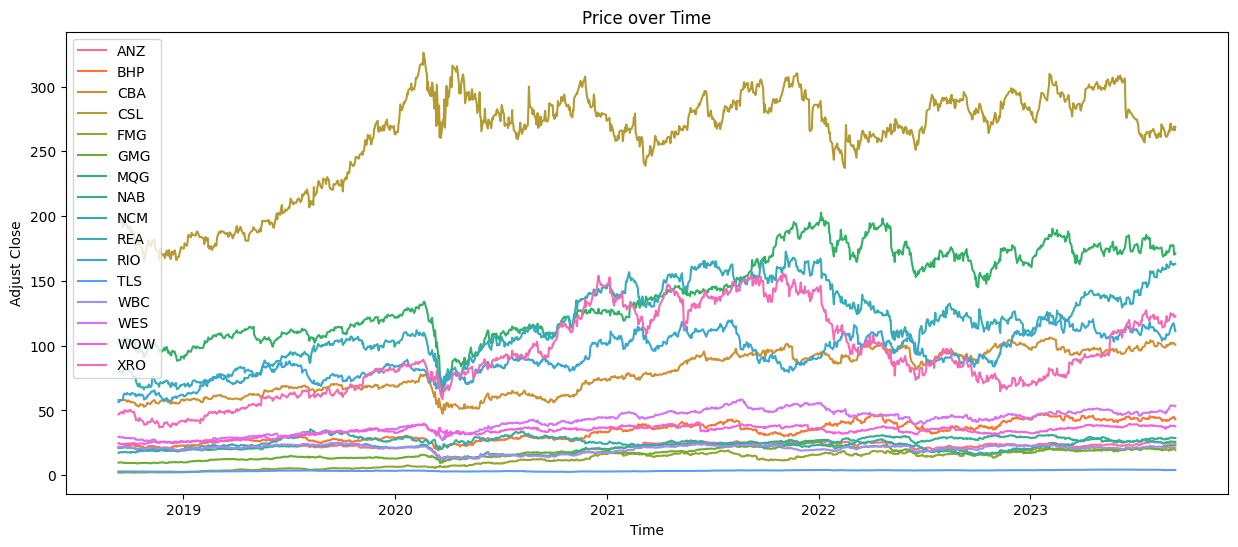

In [15]:
plt.figure(figsize=(15,6))
sns.lineplot(x='Date', y='Adj Close', hue='Ticker', data=data)
plt.xlabel('Time')
plt.ylabel('Adjust Close')
plt.title('Price over Time')
plt.legend()
plt.show()

Regards to this figure, we can see that the price of each stock is increase gradually from the beginning of the data to first quarter of 2020. .In the first quarter of 2020, there was a significal drop of all stock, then most of them flactuates in the following time to now, but the overall trend is slightly up.

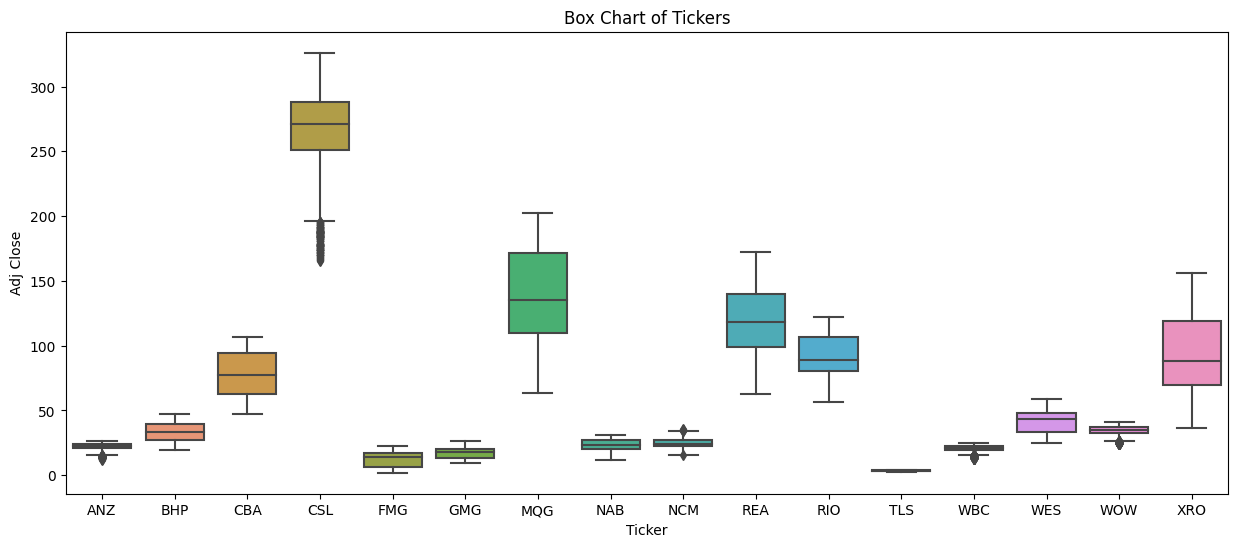

In [16]:
plt.figure(figsize=(15,6))
sns.boxplot(x='Ticker', y='Adj Close', data=data)
plt.xlabel('Ticker')
plt.ylabel('Adj Close')
plt.title('Box Chart of Tickers')
plt.show()

There are 3 different groups. The CSL is outlier of our list, the secound group includes CBA, MQG, REA, RIO, XRO, and then the others. So we divive them to 3 groups.

In [17]:
data1 = data[data['Ticker'] == 'CSL']
data2 = data[data['Ticker'].isin(['CBA', 'MQG', 'REA', 'RIO', 'XRO'])]
data3 = data[data['Ticker'].isin(['ANZ', 'BHP', 'FMG', 'GMG', 'NAB', 'NCM', 'TLS', 'WBC', 'WES', 'WOW'])]


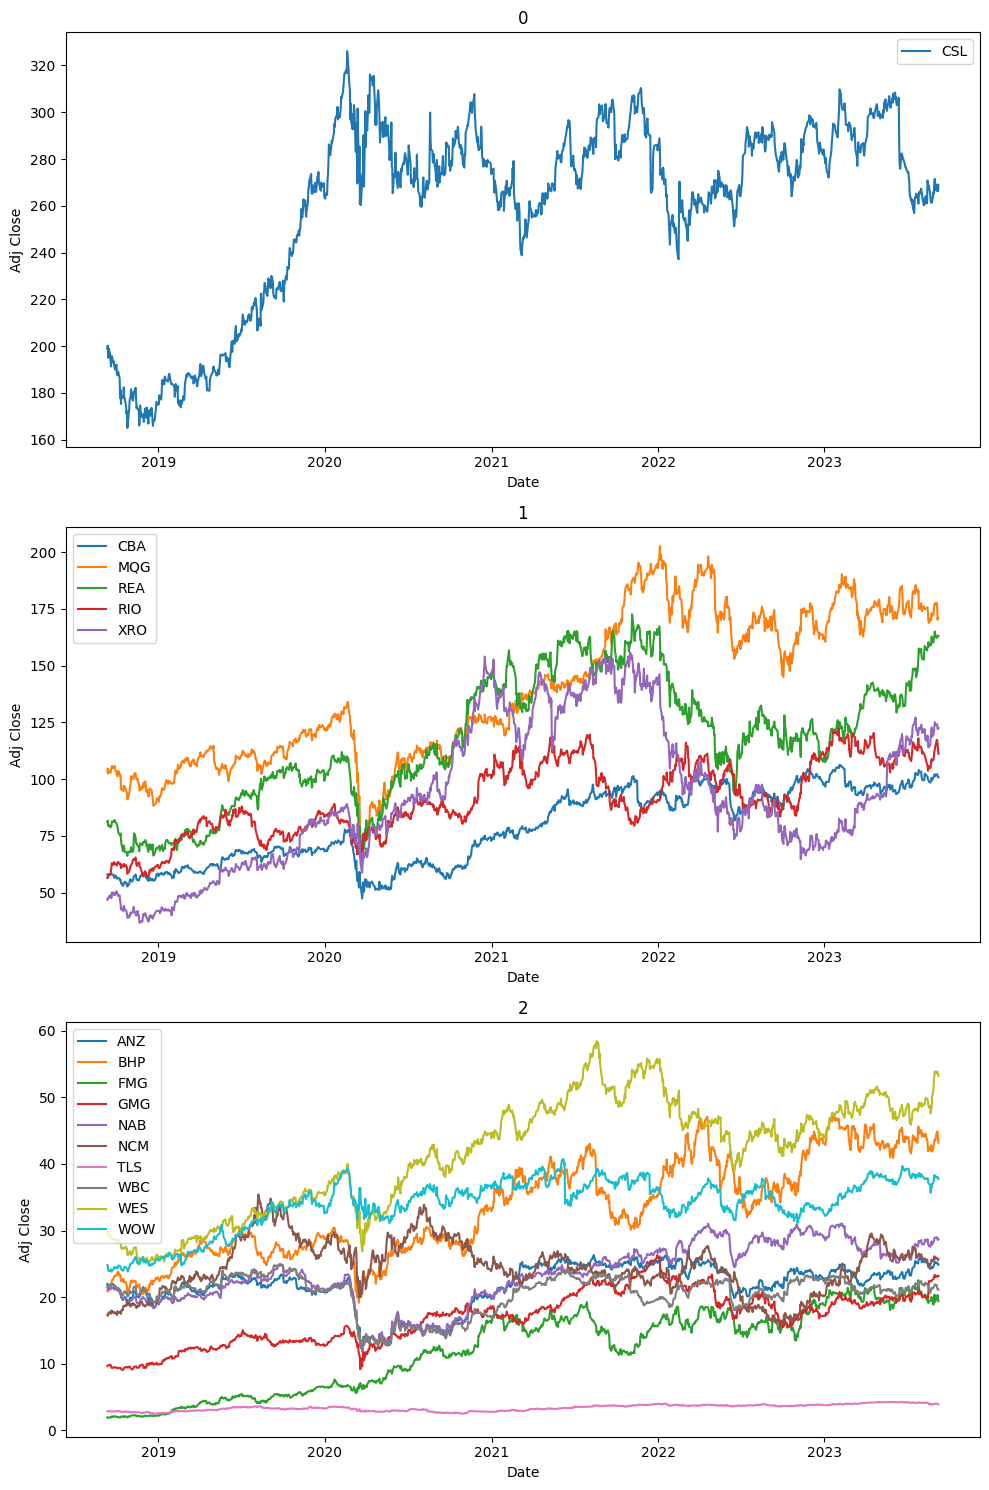

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

for i, df in enumerate([data1, data2, data3]):
  sns.lineplot(data=df, x='Date', y='Adj Close', hue='Ticker',ax=axes[i])
  axes[i].set_title(i)
  axes[i].set_xlabel('Date')
  axes[i].set_ylabel('Adj Close')
  axes[i].legend()
plt.tight_layout()
plt.show()

Now we visualize for each group

<ipython-input-19-eb6a4c0e5a0f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),annot=True)


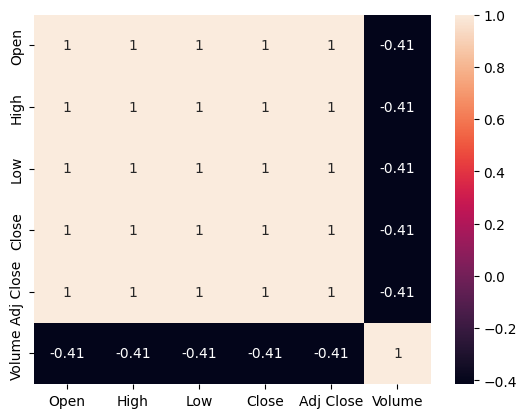

In [19]:
plt.figure()
sns.heatmap(data.corr(),annot=True)
plt.show()

## Time Series Analyze

### Trends

In [20]:
df = data[data['Ticker'] == 'CBA']

<ipython-input-21-bee28f2d0e56>:5: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date', 'Ticker'], dtype='object')
  ).mean()


<Axes: >

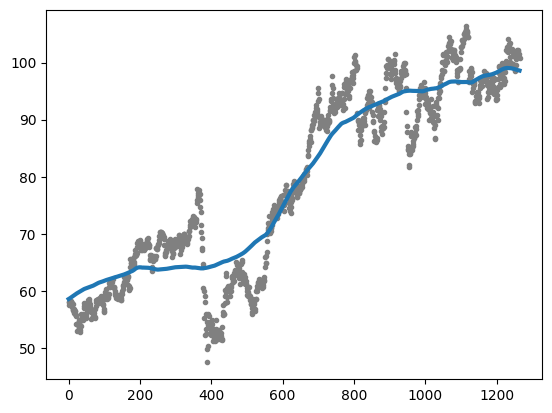

In [21]:
moving_average = df.rolling(
    window=365,
    center=True,
    min_periods=183
).mean()
ax = df['Adj Close'].plot(style='.', color='0.5')
moving_average['Adj Close'].plot(ax=ax, linewidth=3)

As we can see, the overall trend of CBA is increasing.
### Seasonalities

In [22]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


<ipython-input-23-04499b1eb27d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["day"] = df.Date.dt.dayofweek  # the x-axis (freq)
<ipython-input-23-04499b1eb27d>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["week"] = df.Date.dt.week  # the seasonal period (period)
<ipython-input-23-04499b1eb27d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["week"] = df.Date.dt.week  # the seasonal period (period)
<ipython-in

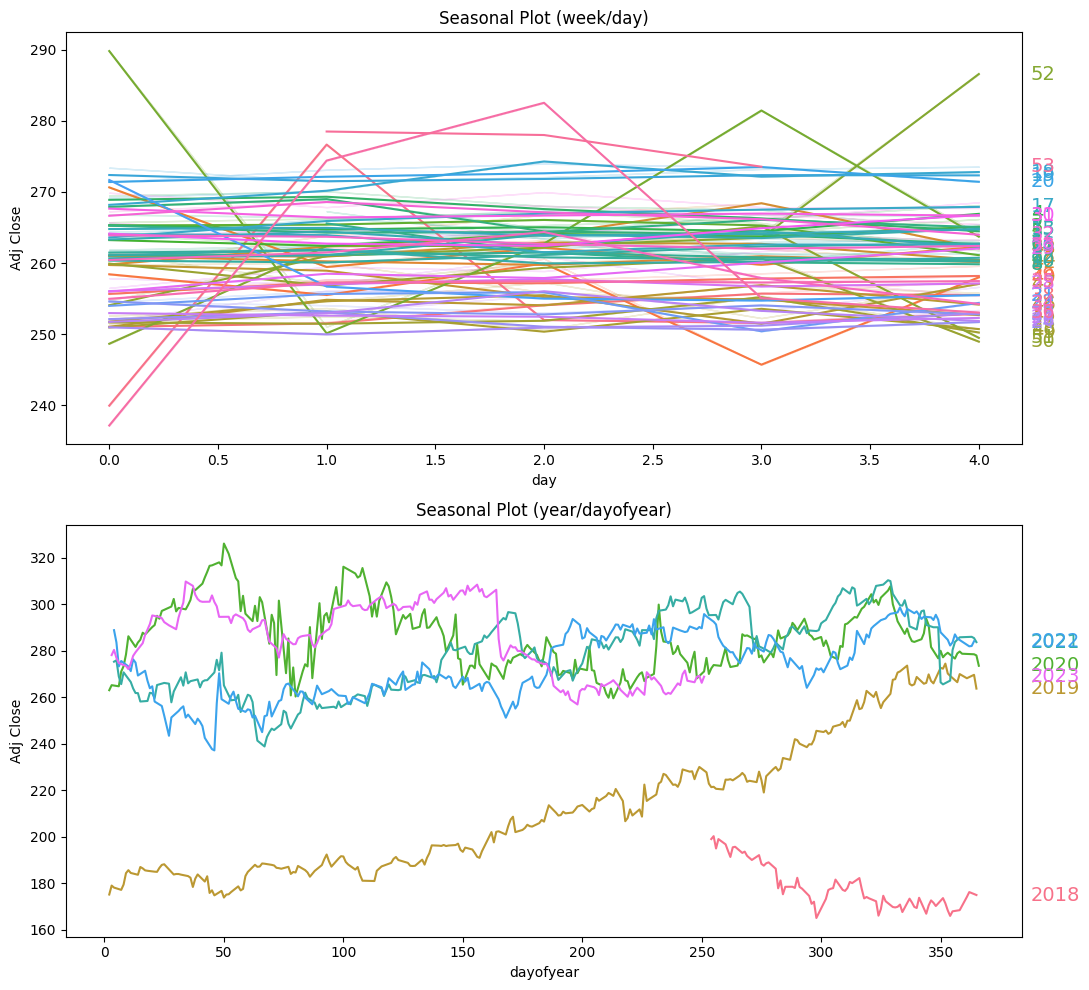

<ipython-input-23-04499b1eb27d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["day"] = df.Date.dt.dayofweek  # the x-axis (freq)
<ipython-input-23-04499b1eb27d>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["week"] = df.Date.dt.week  # the seasonal period (period)
<ipython-input-23-04499b1eb27d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["week"] = df.Date.dt.week  # the seasonal period (period)
<ipython-in

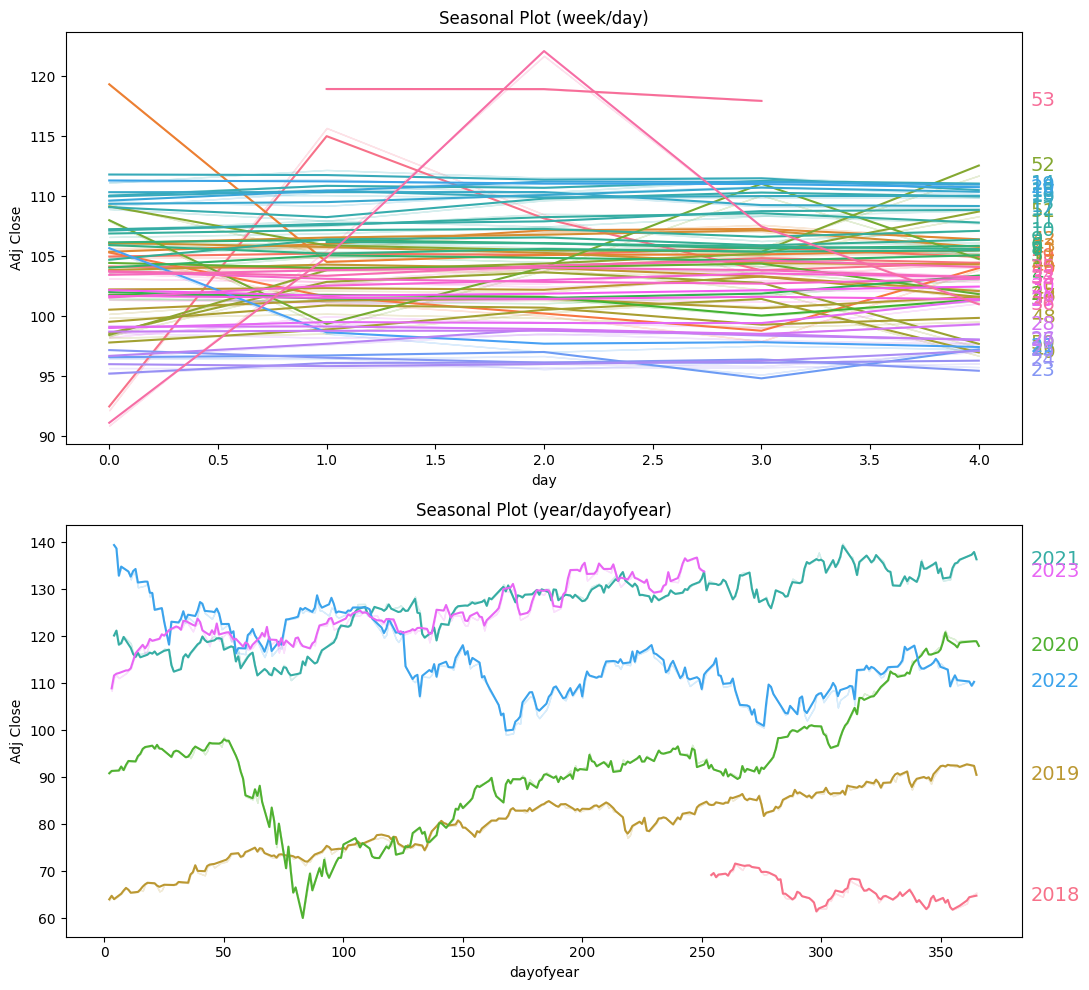

<ipython-input-23-04499b1eb27d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["day"] = df.Date.dt.dayofweek  # the x-axis (freq)
<ipython-input-23-04499b1eb27d>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["week"] = df.Date.dt.week  # the seasonal period (period)
<ipython-input-23-04499b1eb27d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["week"] = df.Date.dt.week  # the seasonal period (period)
<ipython-in

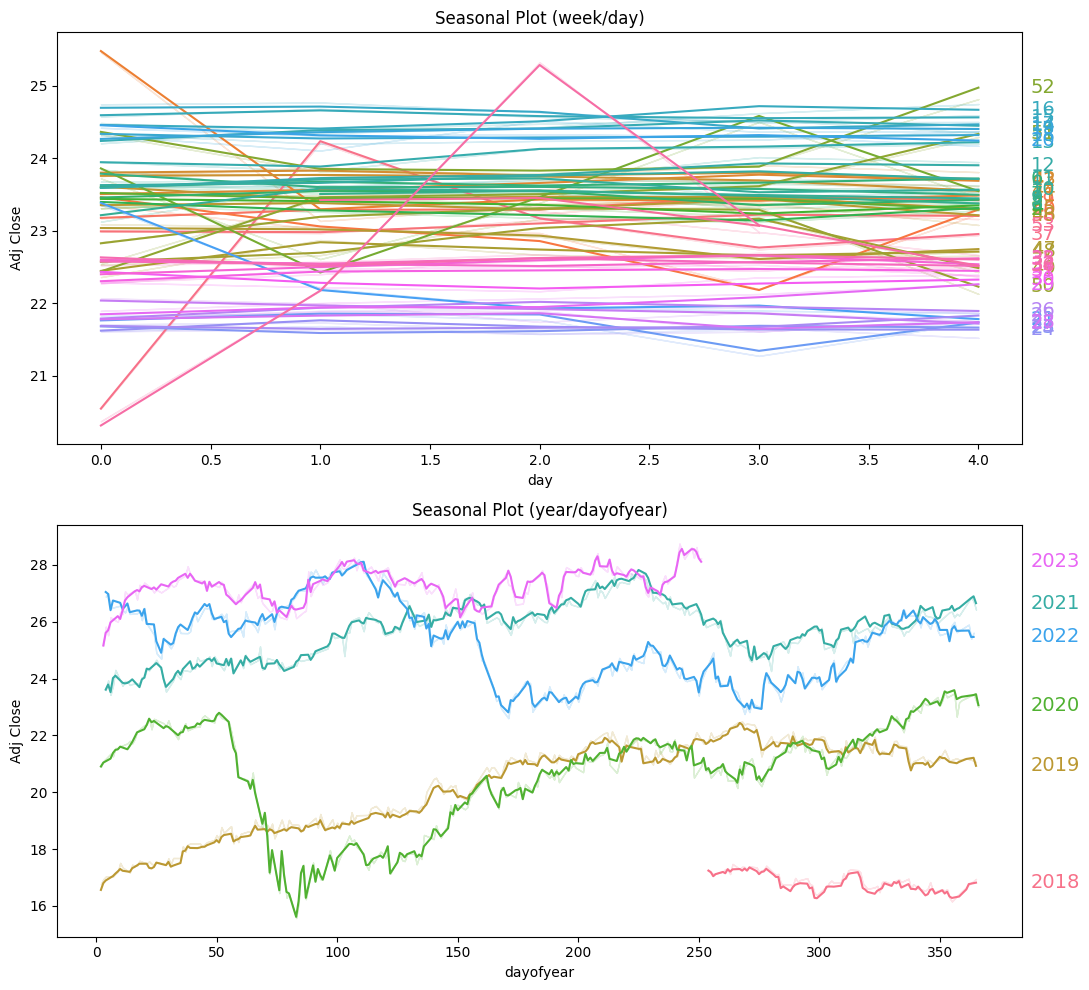

In [23]:
def show_seasonality(df):
  # days within a week
  df["day"] = df.Date.dt.dayofweek  # the x-axis (freq)
  df["week"] = df.Date.dt.week  # the seasonal period (period)

  # days within a year
  df["dayofyear"] = df.Date.dt.dayofyear
  df["year"] = df.Date.dt.year
  fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 10))
  seasonal_plot(df, y="Adj Close", period="week", freq="day", ax=ax0)
  seasonal_plot(df, y="Adj Close", period="year", freq="dayofyear", ax=ax1)
  plt.tight_layout()
  plt.show()

show_seasonality(data1)
show_seasonality(data2)
show_seasonality(data3)


Obviously, our data doesn't have seasonality much.

### Cyclic



In [24]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

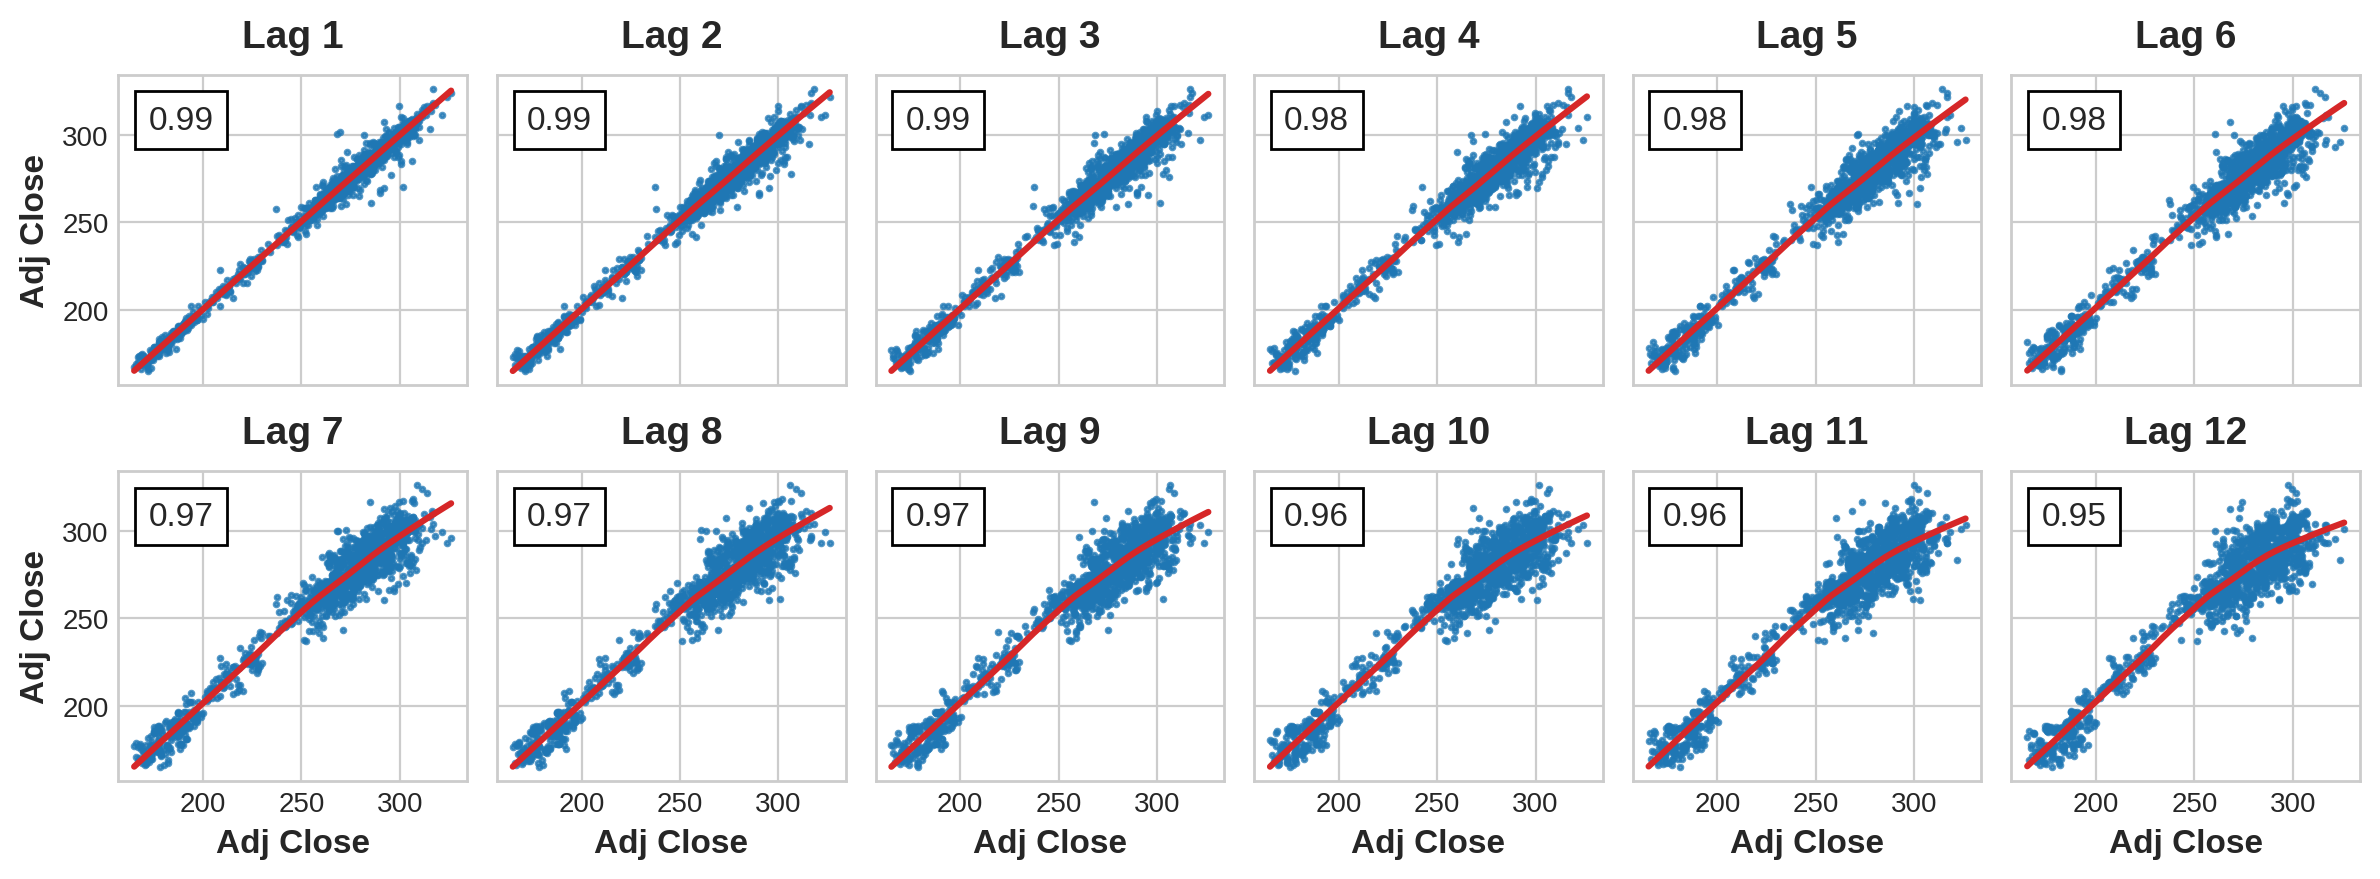

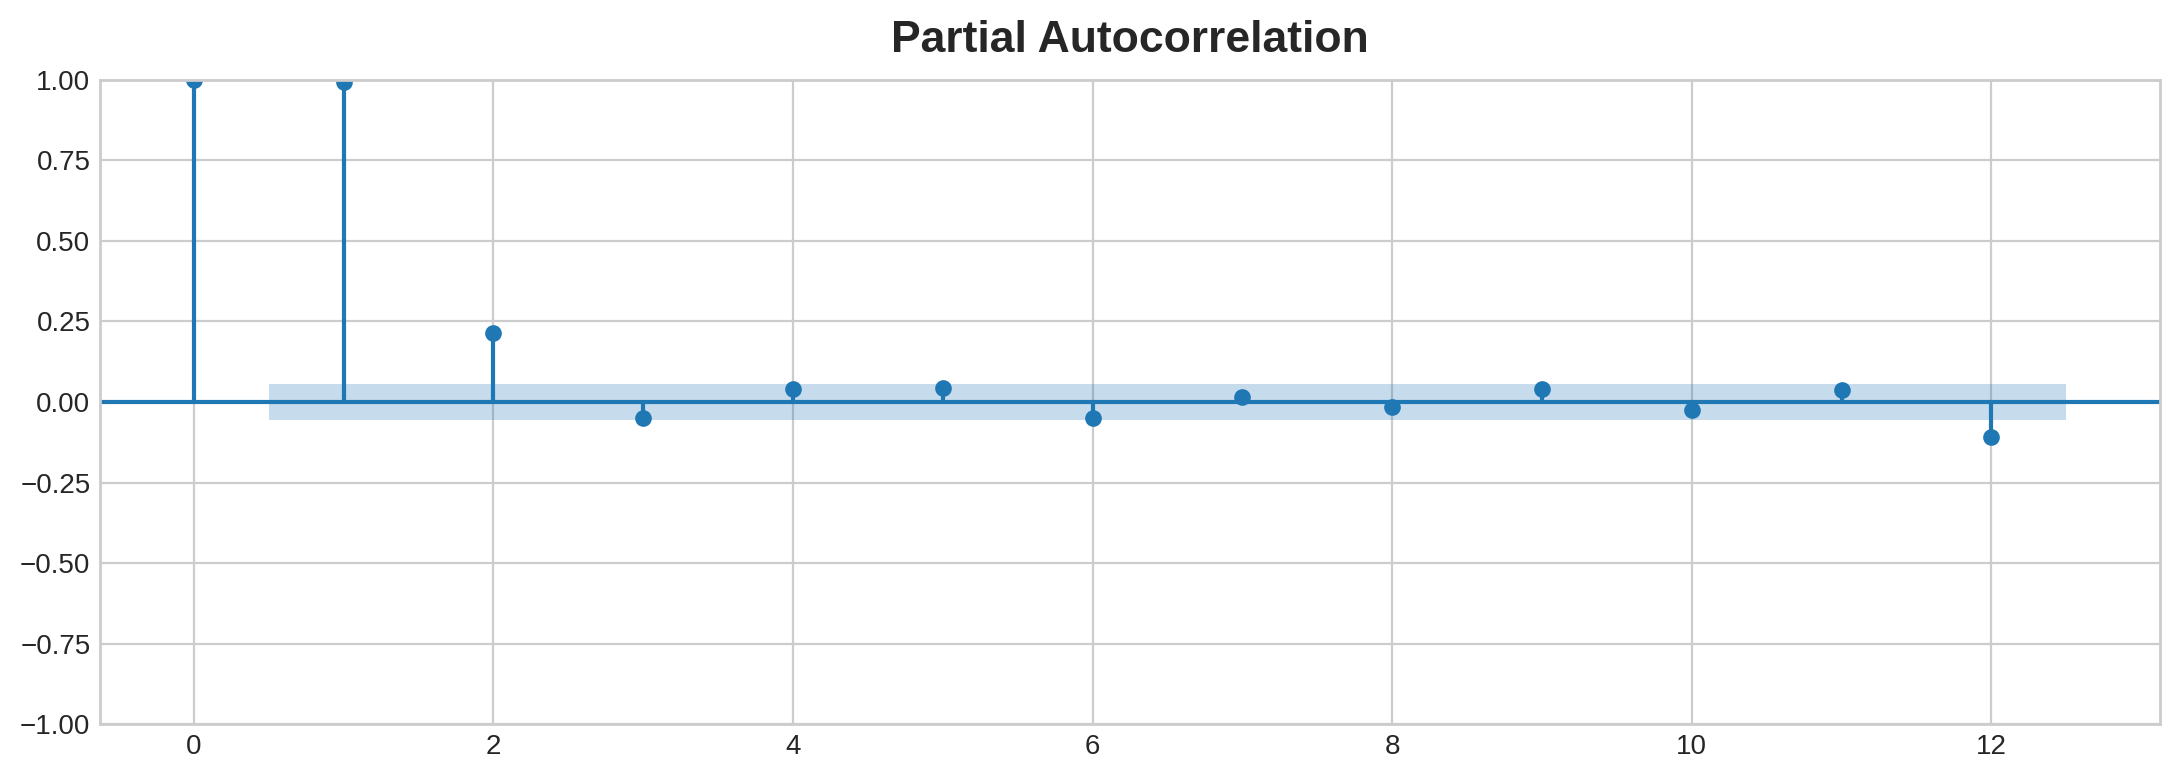

In [25]:
_ = plot_lags(data1['Adj Close'], lags=12, nrows=2)
_ = plot_pacf(data1['Adj Close'], lags=12)

## Feature Engineer

After analyzing time series, I decide to add some features: year, dayofyear, and lag1, lag2.

In [26]:
data.head()

Date       Open       High        Low      Close  Adj Close   Volume  \
0 2018-09-11  28.340000  28.670000  28.330000  28.580000  21.998741  3273782   
1 2018-09-12  28.480000  28.590000  28.309999  28.370001  21.837101  2872094   
2 2018-09-13  28.209999  28.290001  28.030001  28.059999  21.598484  3593758   
3 2018-09-14  28.090000  28.280001  28.090000  28.150000  21.667759  3996645   
4 2018-09-17  28.100000  28.430000  28.049999  28.400000  21.860189  3426323   

  Ticker  
0    ANZ  
1    ANZ  
2    ANZ  
3    ANZ  
4    ANZ

In [27]:
data["Day of year"] = data.Date.dt.dayofyear
data["Year"] = data.Date.dt.year
data['Lag 1'] = data['Adj Close'].shift(1)
data['Lag 2'] = data['Adj Close'].shift(2)
data.loc[data['Date'] == '2018-09-11', 'Lag 1'] =  data.loc[data['Date'] == '2018-09-11', 'Adj Close']
data.loc[data['Date'] == '2018-09-11', 'Lag 2'] =  data.loc[data['Date'] == '2018-09-11', 'Lag 1']
data.loc[data['Date'] == '2018-09-12', 'Lag 2'] =  data.loc[data['Date'] == '2018-09-12', 'Lag 1']
data

Date        Open        High         Low       Close   Adj Close  \
0    2018-09-11   28.340000   28.670000   28.330000   28.580000   21.998741   
1    2018-09-12   28.480000   28.590000   28.309999   28.370001   21.837101   
2    2018-09-13   28.209999   28.290001   28.030001   28.059999   21.598484   
3    2018-09-14   28.090000   28.280001   28.090000   28.150000   21.667759   
4    2018-09-17   28.100000   28.430000   28.049999   28.400000   21.860189   
...         ...         ...         ...         ...         ...         ...   
1260 2023-09-04  125.029999  125.650002  123.070000  123.809998  123.809998   
1261 2023-09-05  123.800003  124.269997  122.080002  124.269997  124.269997   
1262 2023-09-06  124.589996  125.000000  121.580002  122.230003  122.230003   
1263 2023-09-07  123.150002  123.199997  120.900002  122.059998  122.059998   
1264 2023-09-08  122.489998  122.970001  121.760002  122.550003  122.550003   

       Volume Ticker  Day of year  Year       Lag 1       Lag 2  
0     3273782    ANZ          254  2018   21.998741   21.998741  
1     2872094    ANZ          255  2018   21.998741   21.998741  
2     3593758    ANZ          256  2018   21.837101   21.998741  
3     3996645    ANZ          257  2018   21.598484   21.837101  
4     3426323    ANZ          260  2018   21.667759   21.598484  
...       ...    ...          ...   ...         ...         ...  
1260   206305    XRO          247  2023  123.860001  125.099998  
1261   172788    XRO          248  2023  123.809998  123.860001  
1262   237573    XRO          249  2023  124.269997  123.809998  
1263   352021    XRO          250  2023  122.230003  124.269997  
1264   182734    XRO          251  2023  122.059998  122.230003  

[20239 rows x 12 columns]

## Label Encoder

In [28]:
label_encoder = LabelEncoder()

data['Ticker'] = label_encoder.fit_transform(data['Ticker'])

## Machine Learning Model

### Split train and test dataset

In [29]:
data.shape

(20239, 12)

In [30]:
data.head()

Date       Open       High        Low      Close  Adj Close   Volume  \
0 2018-09-11  28.340000  28.670000  28.330000  28.580000  21.998741  3273782   
1 2018-09-12  28.480000  28.590000  28.309999  28.370001  21.837101  2872094   
2 2018-09-13  28.209999  28.290001  28.030001  28.059999  21.598484  3593758   
3 2018-09-14  28.090000  28.280001  28.090000  28.150000  21.667759  3996645   
4 2018-09-17  28.100000  28.430000  28.049999  28.400000  21.860189  3426323   

   Ticker  Day of year  Year      Lag 1      Lag 2  
0       0          254  2018  21.998741  21.998741  
1       0          255  2018  21.998741  21.998741  
2       0          256  2018  21.837101  21.998741  
3       0          257  2018  21.598484  21.837101  
4       0          260  2018  21.667759  21.598484

In [31]:
# Define the date threshold
threshold_date = pd.to_datetime('2022-09-11')

data_train = data[data['Date'] <= threshold_date]
data_test = data[data['Date'] > threshold_date]


In [32]:
X_train = data_train.drop(columns=['Date', 'Adj Close'])
X_test = data_test.drop(columns=['Date', 'Adj Close'])
y_train = data_train['Adj Close']
y_test = data_test['Adj Close']


In [33]:
def data_of_ticker(data_train, data_test, ticker):
  # Extract data of ticker
  train = data_train[data_train['Ticker'] == ticker]
  test = data_test[data_test['Ticker'] == ticker]

  X_train = train.drop(columns=['Date', 'Adj Close'])
  X_test = test.drop(columns=['Date', 'Adj Close'])
  y_train = train['Adj Close']
  y_test = test['Adj Close']

  print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

  return X_train, y_train, X_test, y_test

In [34]:
def show_result(models, data_train, data_test, ticker, train_mode=True):
  X_train, y_train, X_test, y_test = data_of_ticker(data_train, data_test, ticker)
  predictions = []
  for i, model in enumerate(models):
    if train_mode:
      model.fit(X_train, y_train)
    pred = model.predict(X_test)
    predictions.append(pred)
    print(f'Root Mean Squared Error of Model {i}: {mean_squared_error(pred, y_test, squared=False)}')

  # Visualize
  x = range(len(y_test))
  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(111)
  plt.plot(x, y_test, label='Actual Price')
  # plt.plot(x, prediction, '#0000FF', label='Predicted Price')
  for i, pred in enumerate(predictions):
    label = f'Prediction {i}'
    plt.plot(x, pred, label=label)
  plt.legend()
  plt.show()

  return predictions, y_test

### Hybrid Model
I found a really interesting [lesson](https://www.kaggle.com/code/ryanholbrook/hybrid-models#Introduction) in Kaggle about Hybrid Models for forecasting, so why don't try it first.

Basically, you can understand that Hybrid Model I use in the this notebook like this way: I will use 2 different models, this first one try to learn fit with the original data (X_train, y_train), some models excels at learning path and trend of data, however, sometimes they can not fit well with the flactuating data like stock prices, so I use the other model to learning from the error of the first one to improve the results. Very understandable, right?

In [35]:
class HybridModel:
  def __init__(self, model1, model2):
    self.model1 = model1
    self.model2 = model2

  def fit(self, X_train, y_train):
    # Train model 1
    self.model1.fit(X_train, y_train)
    pred1 = self.model1.predict(X_train)

    # Train model 2 with the labels is substraction of y_train and prediction of model 1
    self.model2.fit(X_train, y_train-pred1)

  def predict(self, X_test):
    pred1 = self.model1.predict(X_test)
    pred2 = self.model2.predict(X_test)
    return pred1+pred2

In [36]:
# Recommended Models
# Model 1 (trend)
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

model1 = HybridModel(
    model1 = LinearRegression(),
    model2 = XGBRegressor(random_state=42)
)
model2 = HybridModel(
    model1 = ElasticNet(random_state=42),
    model2 = RandomForestRegressor(random_state=42)
)
model3 = HybridModel(
    model1 = Ridge(random_state=42),
    model2 = KNeighborsRegressor()
)


(1014, 10) (1014,) (251, 10) (251,)
Root Mean Squared Error of Model 0: 0.23474726010408276
Root Mean Squared Error of Model 1: 0.4975381892409635
Root Mean Squared Error of Model 2: 0.21208926173955872


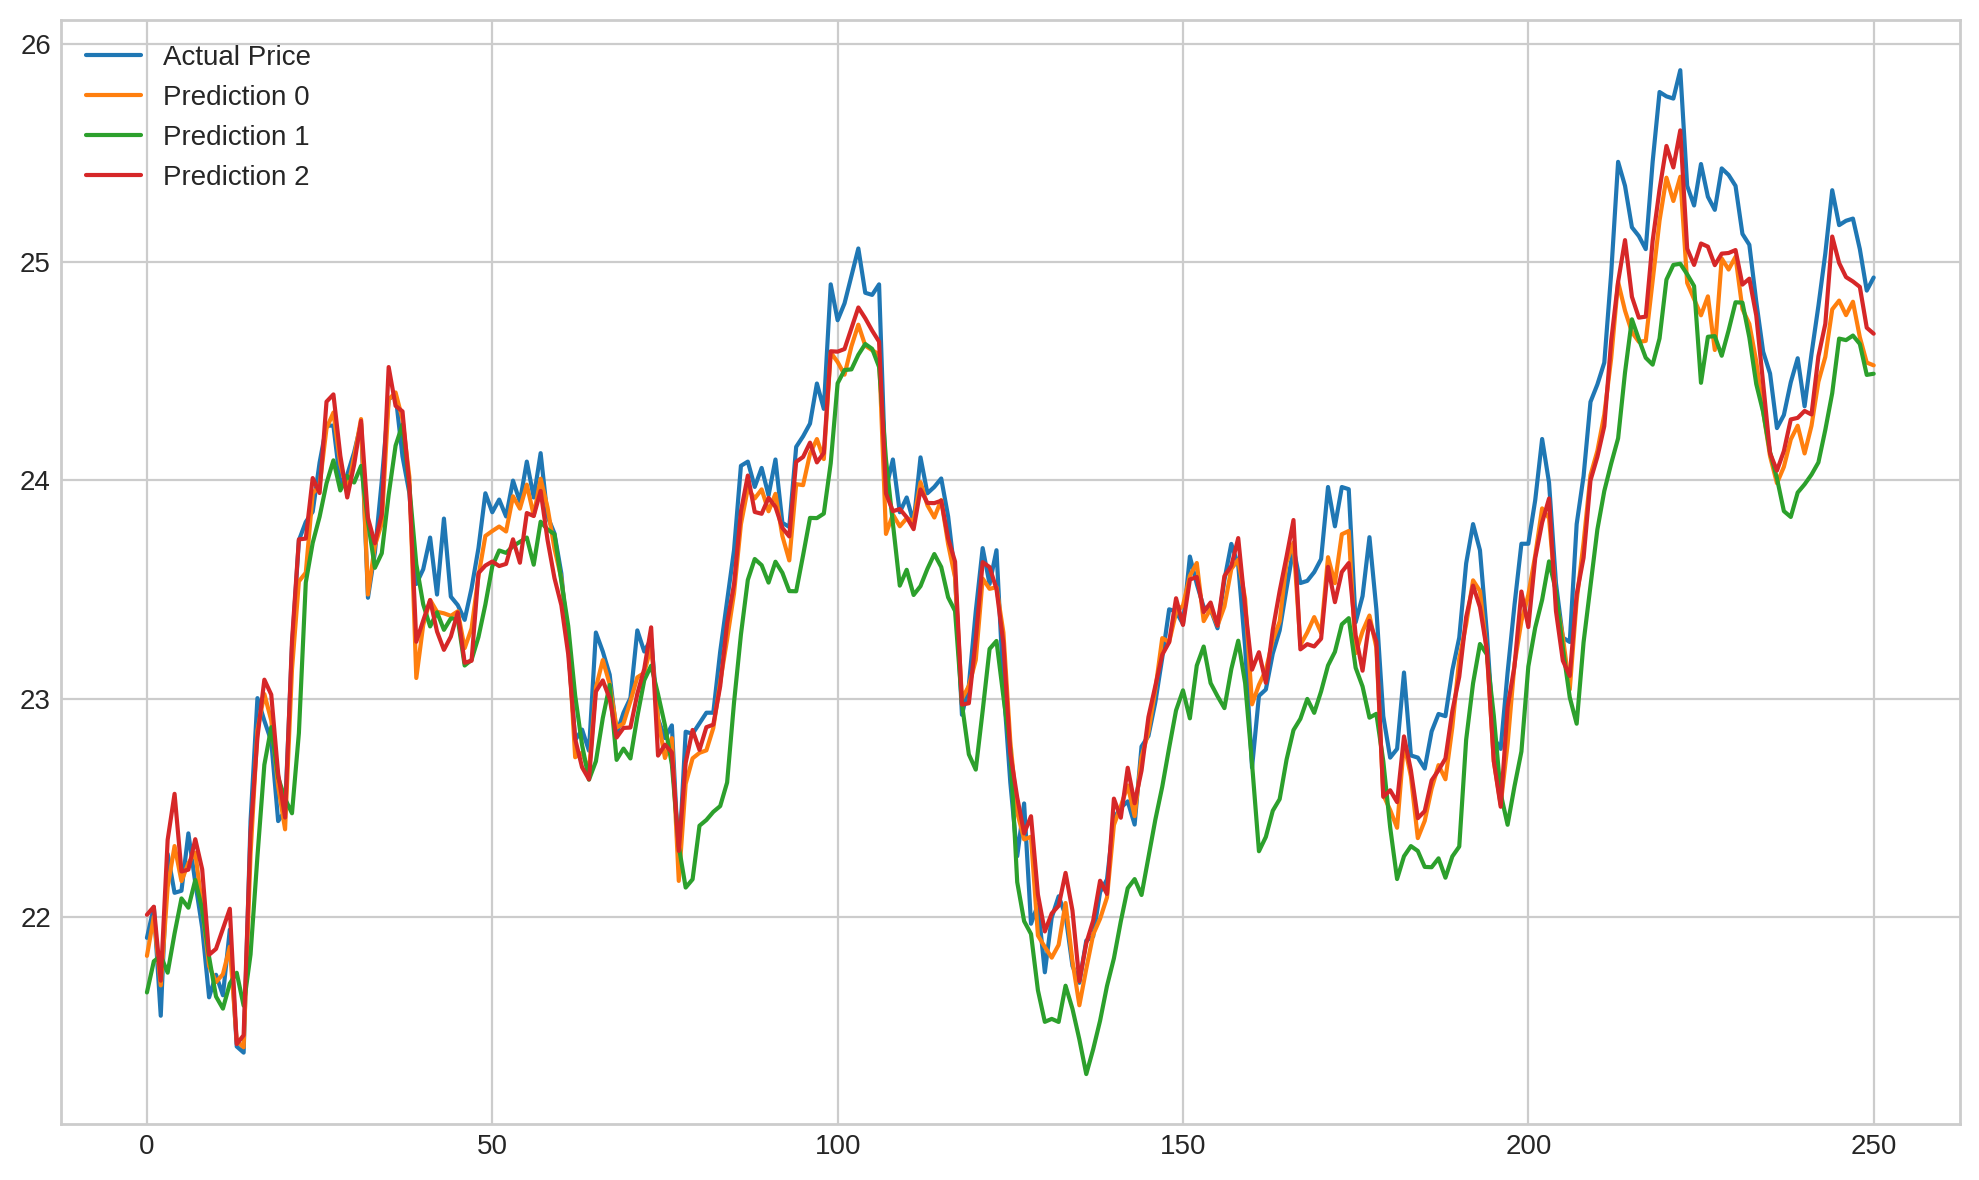

In [37]:
# Get result of each model
pred, act = show_result([model1, model2, model3], data_train, data_test, 0)

In this stage, I'm not sure that should I continue with another model because the result as we can see is pretty appropriate :) (Just kidding!)

Additionally, we can see model1 is the best model which get RMSE: 0.007 (James Bond :>) so I should remember it.

### AMIRA Model
AMIRA (AutoRegressive Integrated Moving Average) is a time series forecasting model used to make predictions based on past data. It models the time series as a combination of autoregressive (AR) and moving average (MA) components, and incorporates differencing to remove non-stationarity. ARIMA is commonly used for univariate time series analysis, where a single variable is observed over time.

The model is specified by three parameters:

- p: order of autoregressive component
- d: order of differencing
- q: order of moving average component

Now, let try!

In [38]:
# Select data of ticker for getting result
X_train2, y_train2, X_test2, y_test2 = data_of_ticker(data_train, data_test, 5)

# split into train and test sets
# predictions = list()
# y_test2 = y_test2.to_list()
# y_train2 = y_train2.to_list()
# history = y_train2

# Implement ARIMA model
arima_model = ARIMA(y_train2, order=(1,2,3))

(1014, 10) (1014,) (251, 10) (251,)


In [39]:
fit_model = arima_model.fit()
print(fit_model.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1014
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -223.600
Date:                Wed, 13 Sep 2023   AIC                            457.201
Time:                        08:12:29   BIC                            481.799
Sample:                             0   HQIC                           466.545
                               - 1014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9461      0.581     -1.629      0.103      -2.084       0.192
ma.L1         -0.1501      0.580     -0.259      0.796      -1.287       0.987
ma.L2         -0.9417      0.631     -1.493      0.1

In [40]:
pred = fit_model.forecast(len(y_test2))
pred

1014    18.763985
1015    18.775938
1016    18.779348
1017    18.790840
1018    18.794686
          ...    
1260    20.626732
1261    20.634295
1262    20.641858
1263    20.649421
1264    20.656984
Name: predicted_mean, Length: 251, dtype: float64

In [41]:
mean_squared_error(pred, y_test2, squared=False)

1.3914066965880503

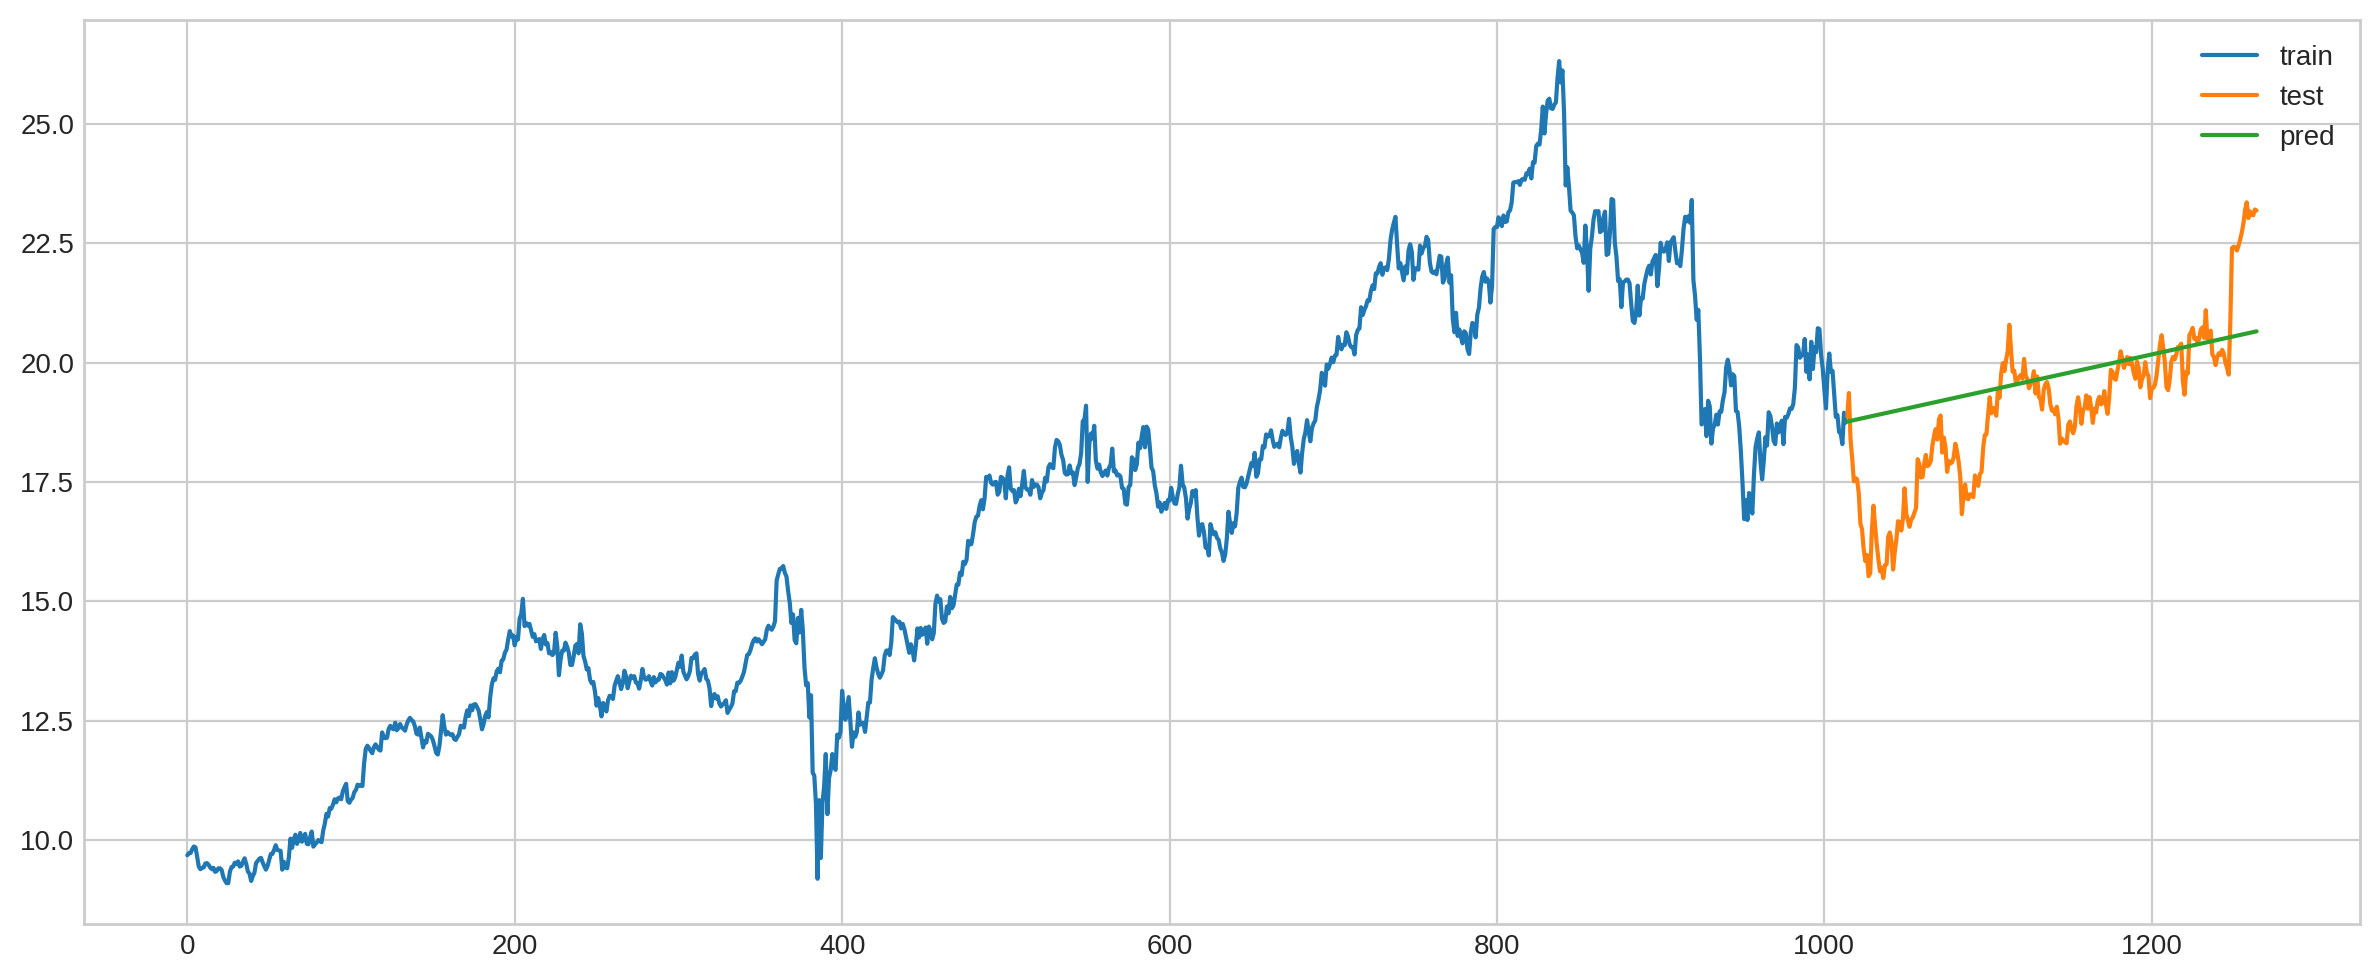

In [42]:
plt.figure(figsize=(12, 5))
plt.plot(y_train2, label='train')
plt.plot(y_test2, label='test')
plt.plot(pred, label='pred')
plt.legend()
plt.show()


#### Perform Grid Search for fine-tune parameter

In [43]:
rang = range(4)
l = []
for p in rang:
  for d in rang:
    for q in rang:
      l.append((p, d, q))

In [44]:
# # @title Default title text
# # Select data of ticker for getting result
# X_train2, y_train2, X_test2, y_test2 = data_of_ticker(data_train, data_test, 5)
# results = []

# # Select the best params
# for params in l:
#   arima_model = ARIMA(y_train2, order=params)
#   fit_model = arima_model.fit()
#   pred = fit_model.forecast(len(y_test2))
#   err = mean_squared_error(pred, y_test2, squared=False)
#   results.append(err)
#   print(f'params {params} has RMSE {err}')


# results = pd.DataFrame(results)

It's supposed that there are not big difference when we change the params of ARIMA model, from this grid search the best params is (1,2,3). So we will use it for further.

### Prophet Model
Prophet is a time series forecasting model developed by Facebook’s Core Data Science team. It is a statistical model that uses an additive approach to capture various components of a time series, including trends, seasonality, holidays, and other effects. Prophet also employs Bayesian modeling techniques to estimate model parameters and uncertainty, which helps to provide more accurate predictions and forecast intervals.

In [45]:
# Prepare data for Prophet Model
ticker = 5 # data of ticker for train
data_prophet = data[data['Ticker'] == ticker][['Date', 'Adj Close']]
data_prophet.columns = ('ds', 'y')

# Split train and test
threshold_date = pd.to_datetime('2022-09-12')
data_train_pp, data_test_pp = data_prophet[data_prophet['ds'] < threshold_date], data_prophet[data_prophet['ds'] >= threshold_date]

In [46]:
print(data_train_pp.shape, data_test_pp.shape)

(1014, 2) (251, 2)


In [47]:
# Train Prophet Model
pp_model = Prophet()
pp_model.fit(data_train_pp)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptq1hpehn/ooy35ej4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptq1hpehn/oipakky9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69481', 'data', 'file=/tmp/tmptq1hpehn/ooy35ej4.json', 'init=/tmp/tmptq1hpehn/oipakky9.json', 'output', 'file=/tmp/tmptq1hpehn/prophet_modelmuh0s0r6/prophet_model-20230913081230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:12:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:12:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [48]:
future = data_test_pp[['ds']]
pred_pp = pp_model.predict(future)
pred_pp.tail()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
246 2023-09-04  11.686239    6.380013   17.818321     6.133270    17.423574   
247 2023-09-05  11.667655    6.237804   17.615230     6.083302    17.438980   
248 2023-09-06  11.649071    5.962931   17.763289     6.045362    17.454388   
249 2023-09-07  11.630487    6.019947   17.824131     5.999235    17.477954   
250 2023-09-08  11.611903    5.970420   17.825602     5.952995    17.505073   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
246        0.173829              0.173829              0.173829 -0.105713   
247        0.161524              0.161524              0.161524 -0.081703   
248        0.151133              0.151133              0.151133 -0.057862   
249        0.127120              0.127120              0.127120 -0.049705   
250        0.107006              0.107006              0.107006 -0.039630   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
246     -0.105713     -0.105713  0.279542      0.279542      0.279542   
247     -0.081703     -0.081703  0.243227      0.243227      0.243227   
248     -0.057862     -0.057862  0.208995      0.208995      0.208995   
249     -0.049705     -0.049705  0.176825      0.176825      0.176825   
250     -0.039630     -0.039630  0.146636      0.146636      0.146636   

     multiplicative_terms  multiplicative_terms_lower  \
246                   0.0                         0.0   
247                   0.0                         0.0   
248                   0.0                         0.0   
249                   0.0                         0.0   
250                   0.0                         0.0   

     multiplicative_terms_upper       yhat  
246                         0.0  11.860068  
247                         0.0  11.829179  
248                         0.0  11.800204  
249                         0.0  11.757607  
250                         0.0  11.718909

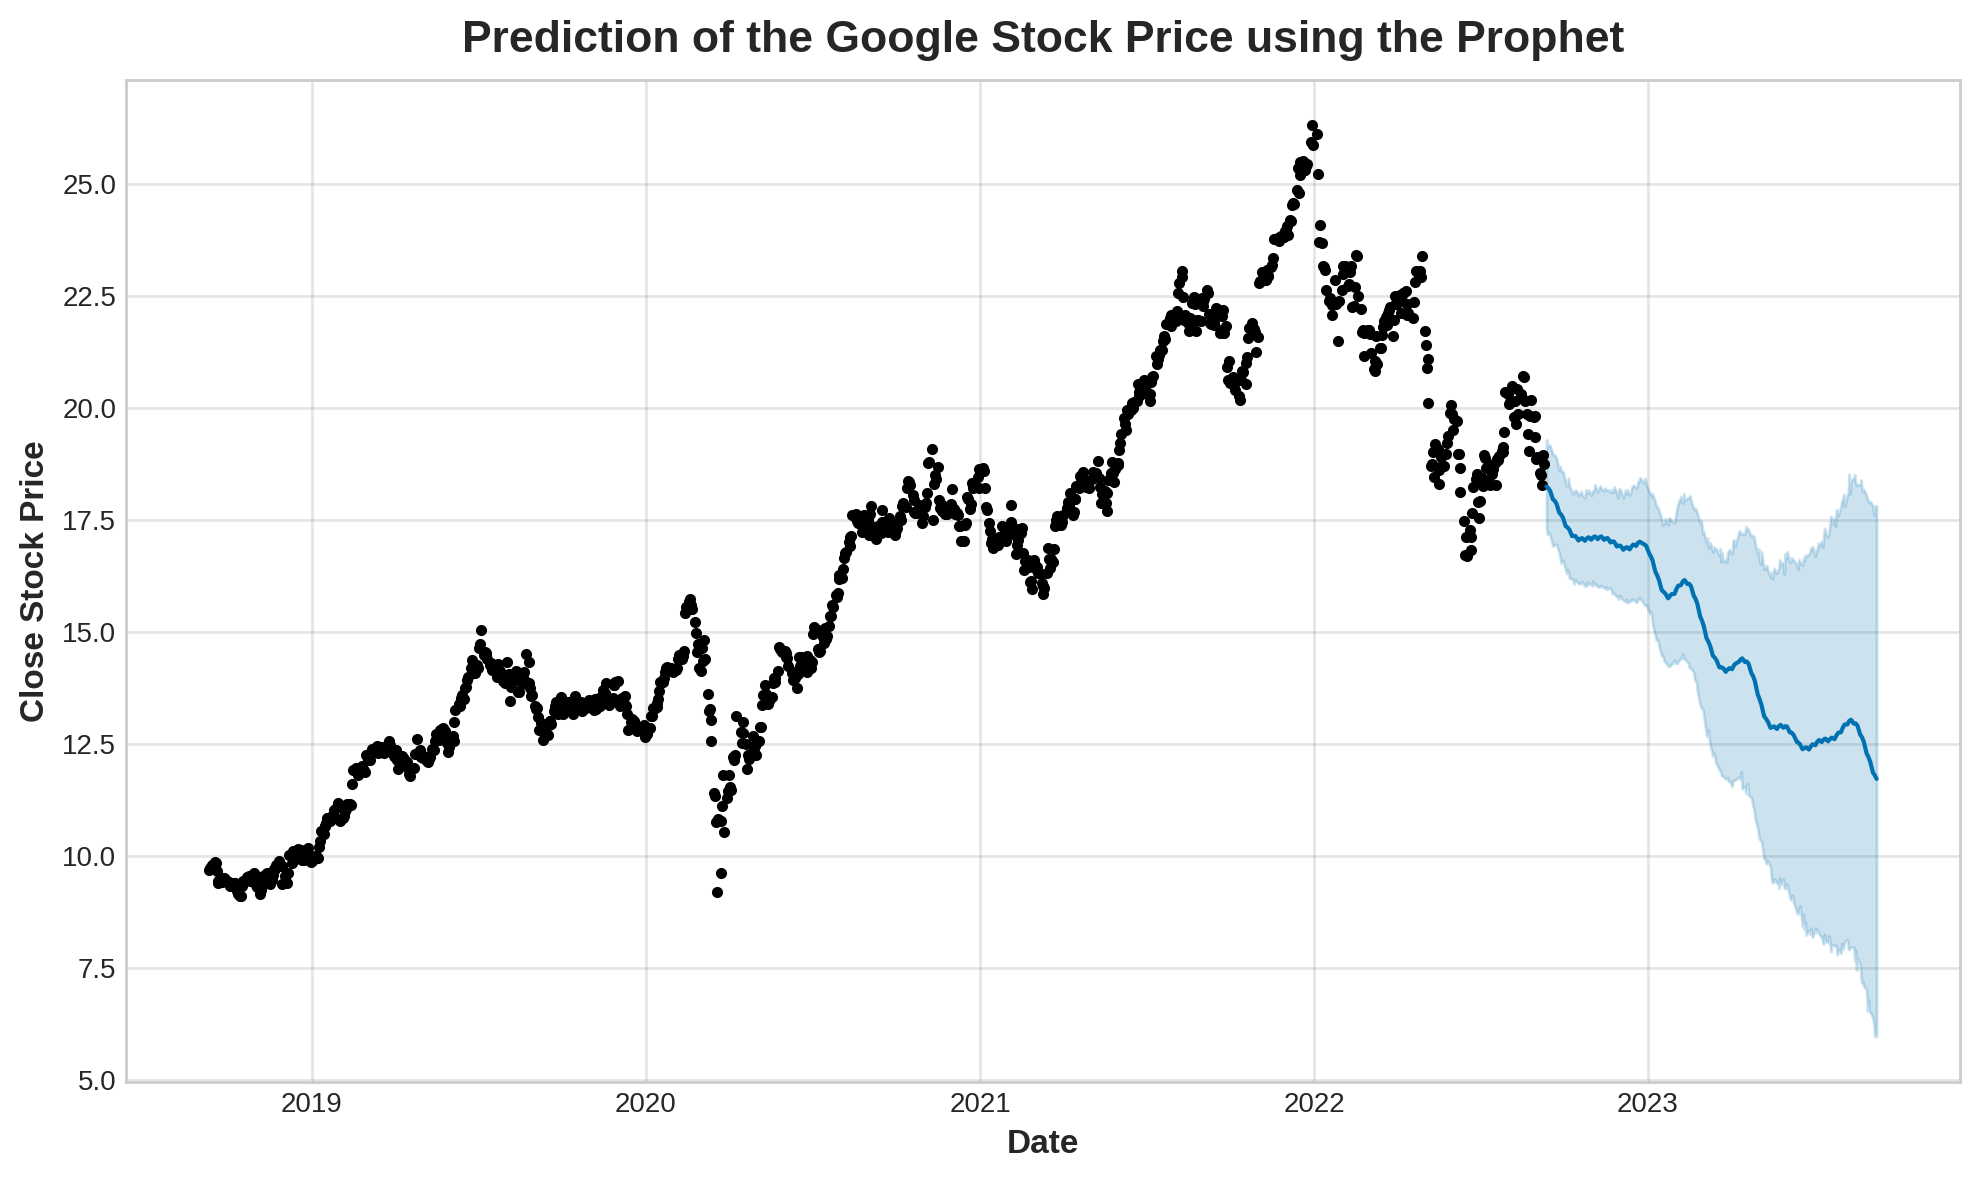

In [49]:
pp_model.plot(pred_pp)
plt.title("Prediction of the Google Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

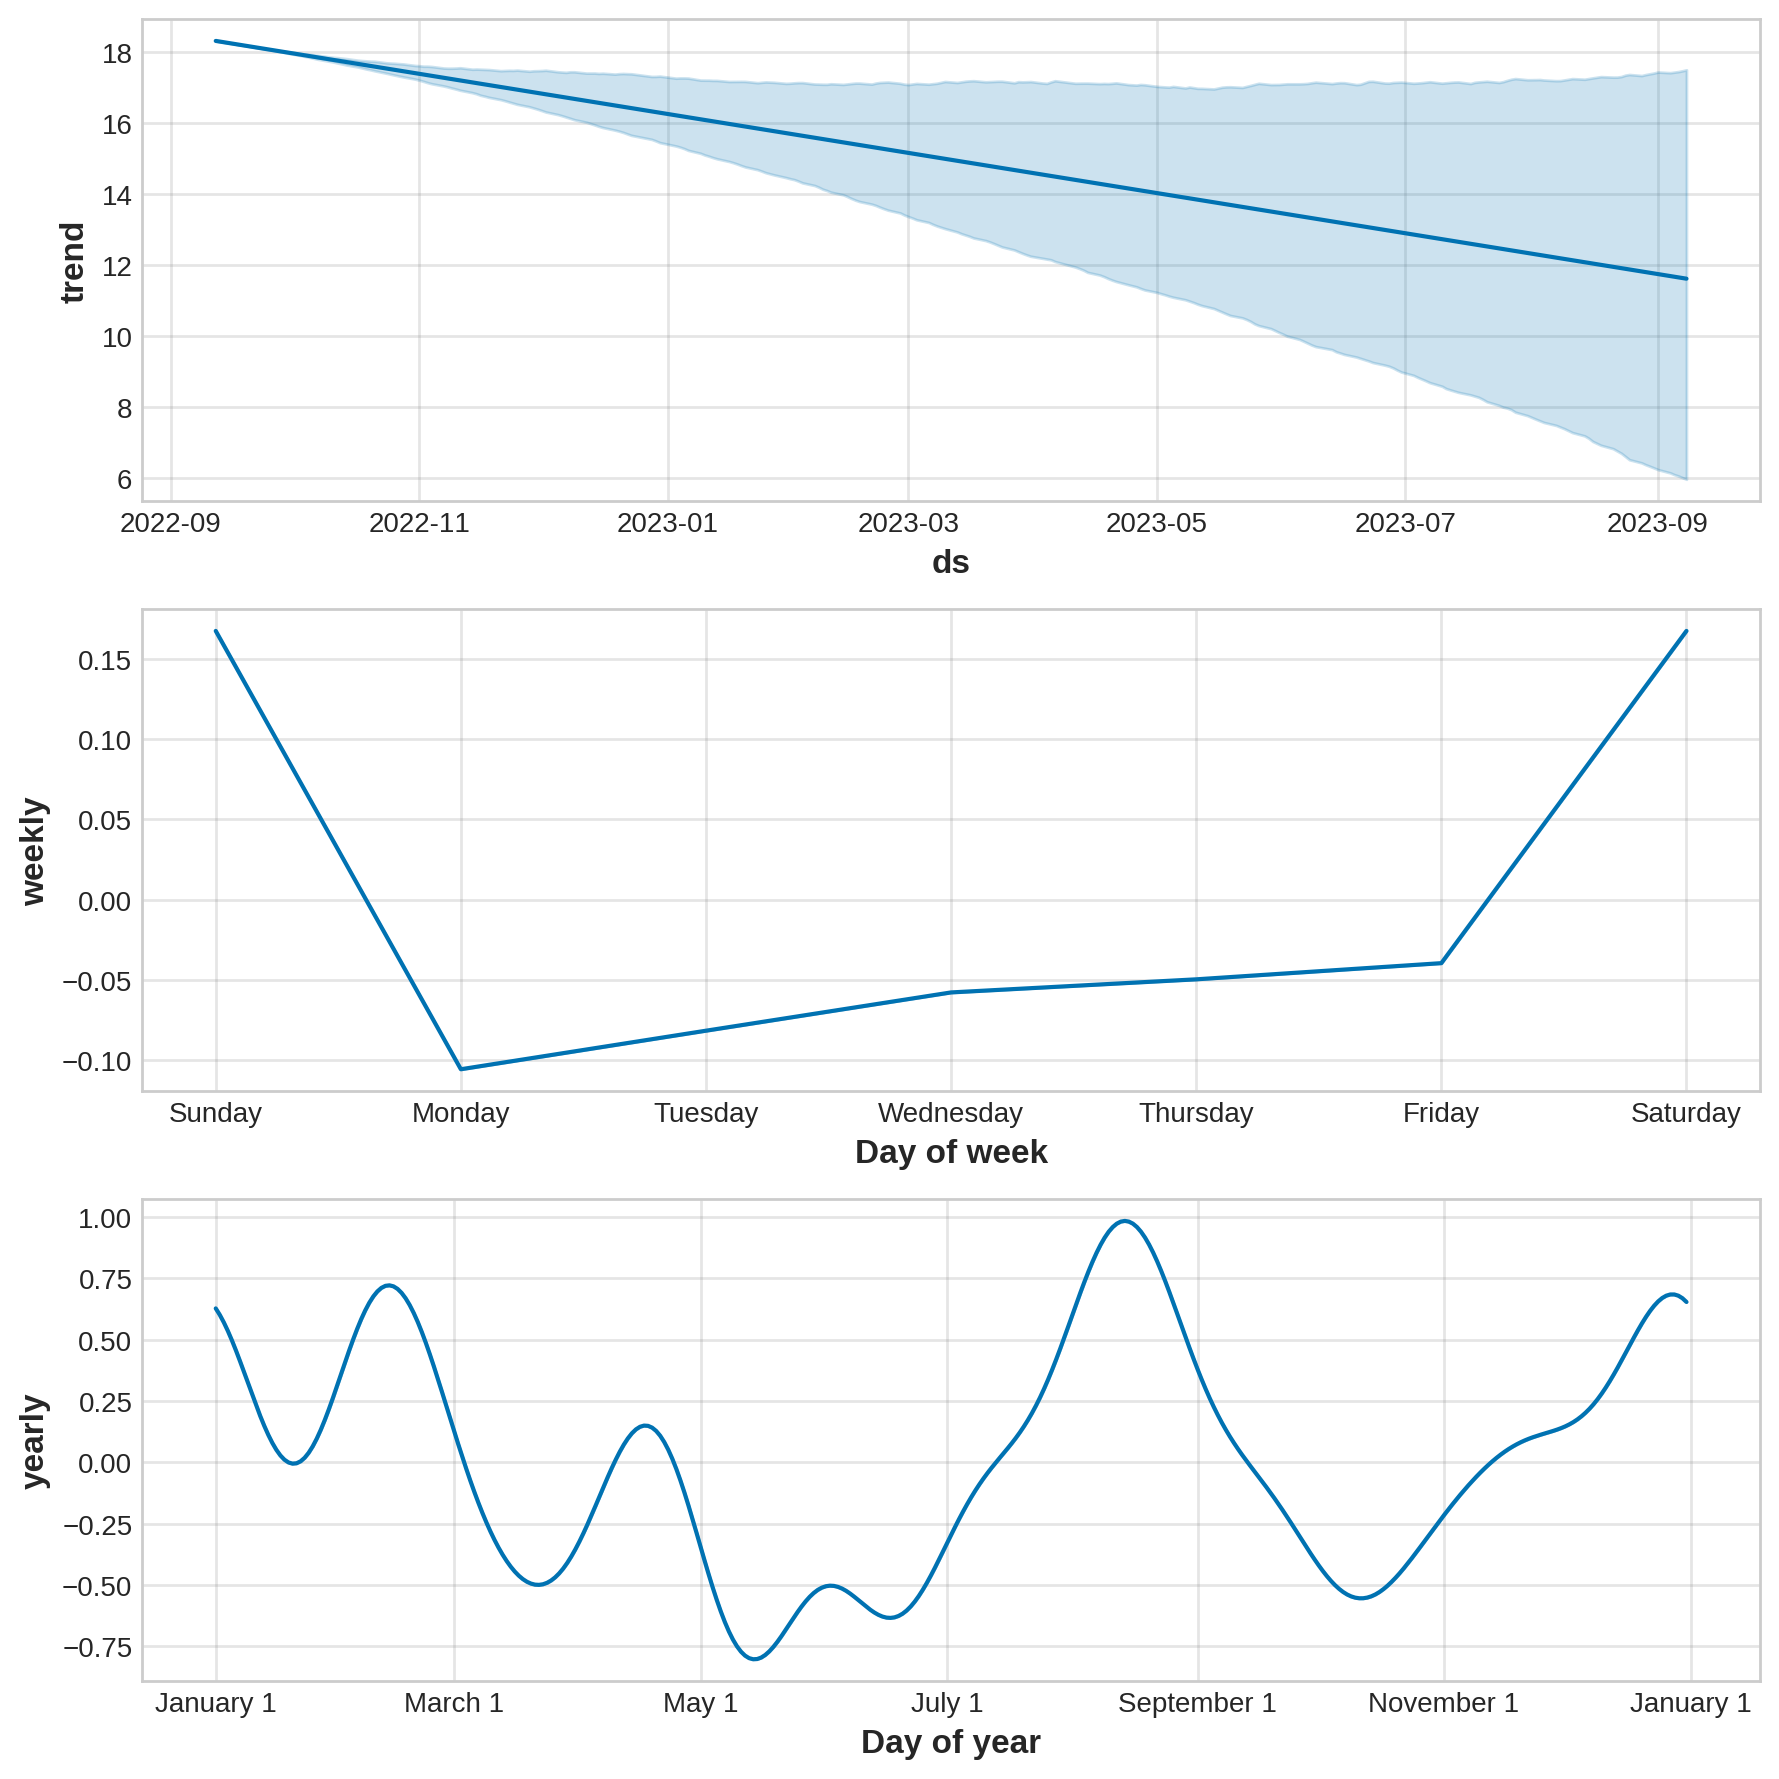

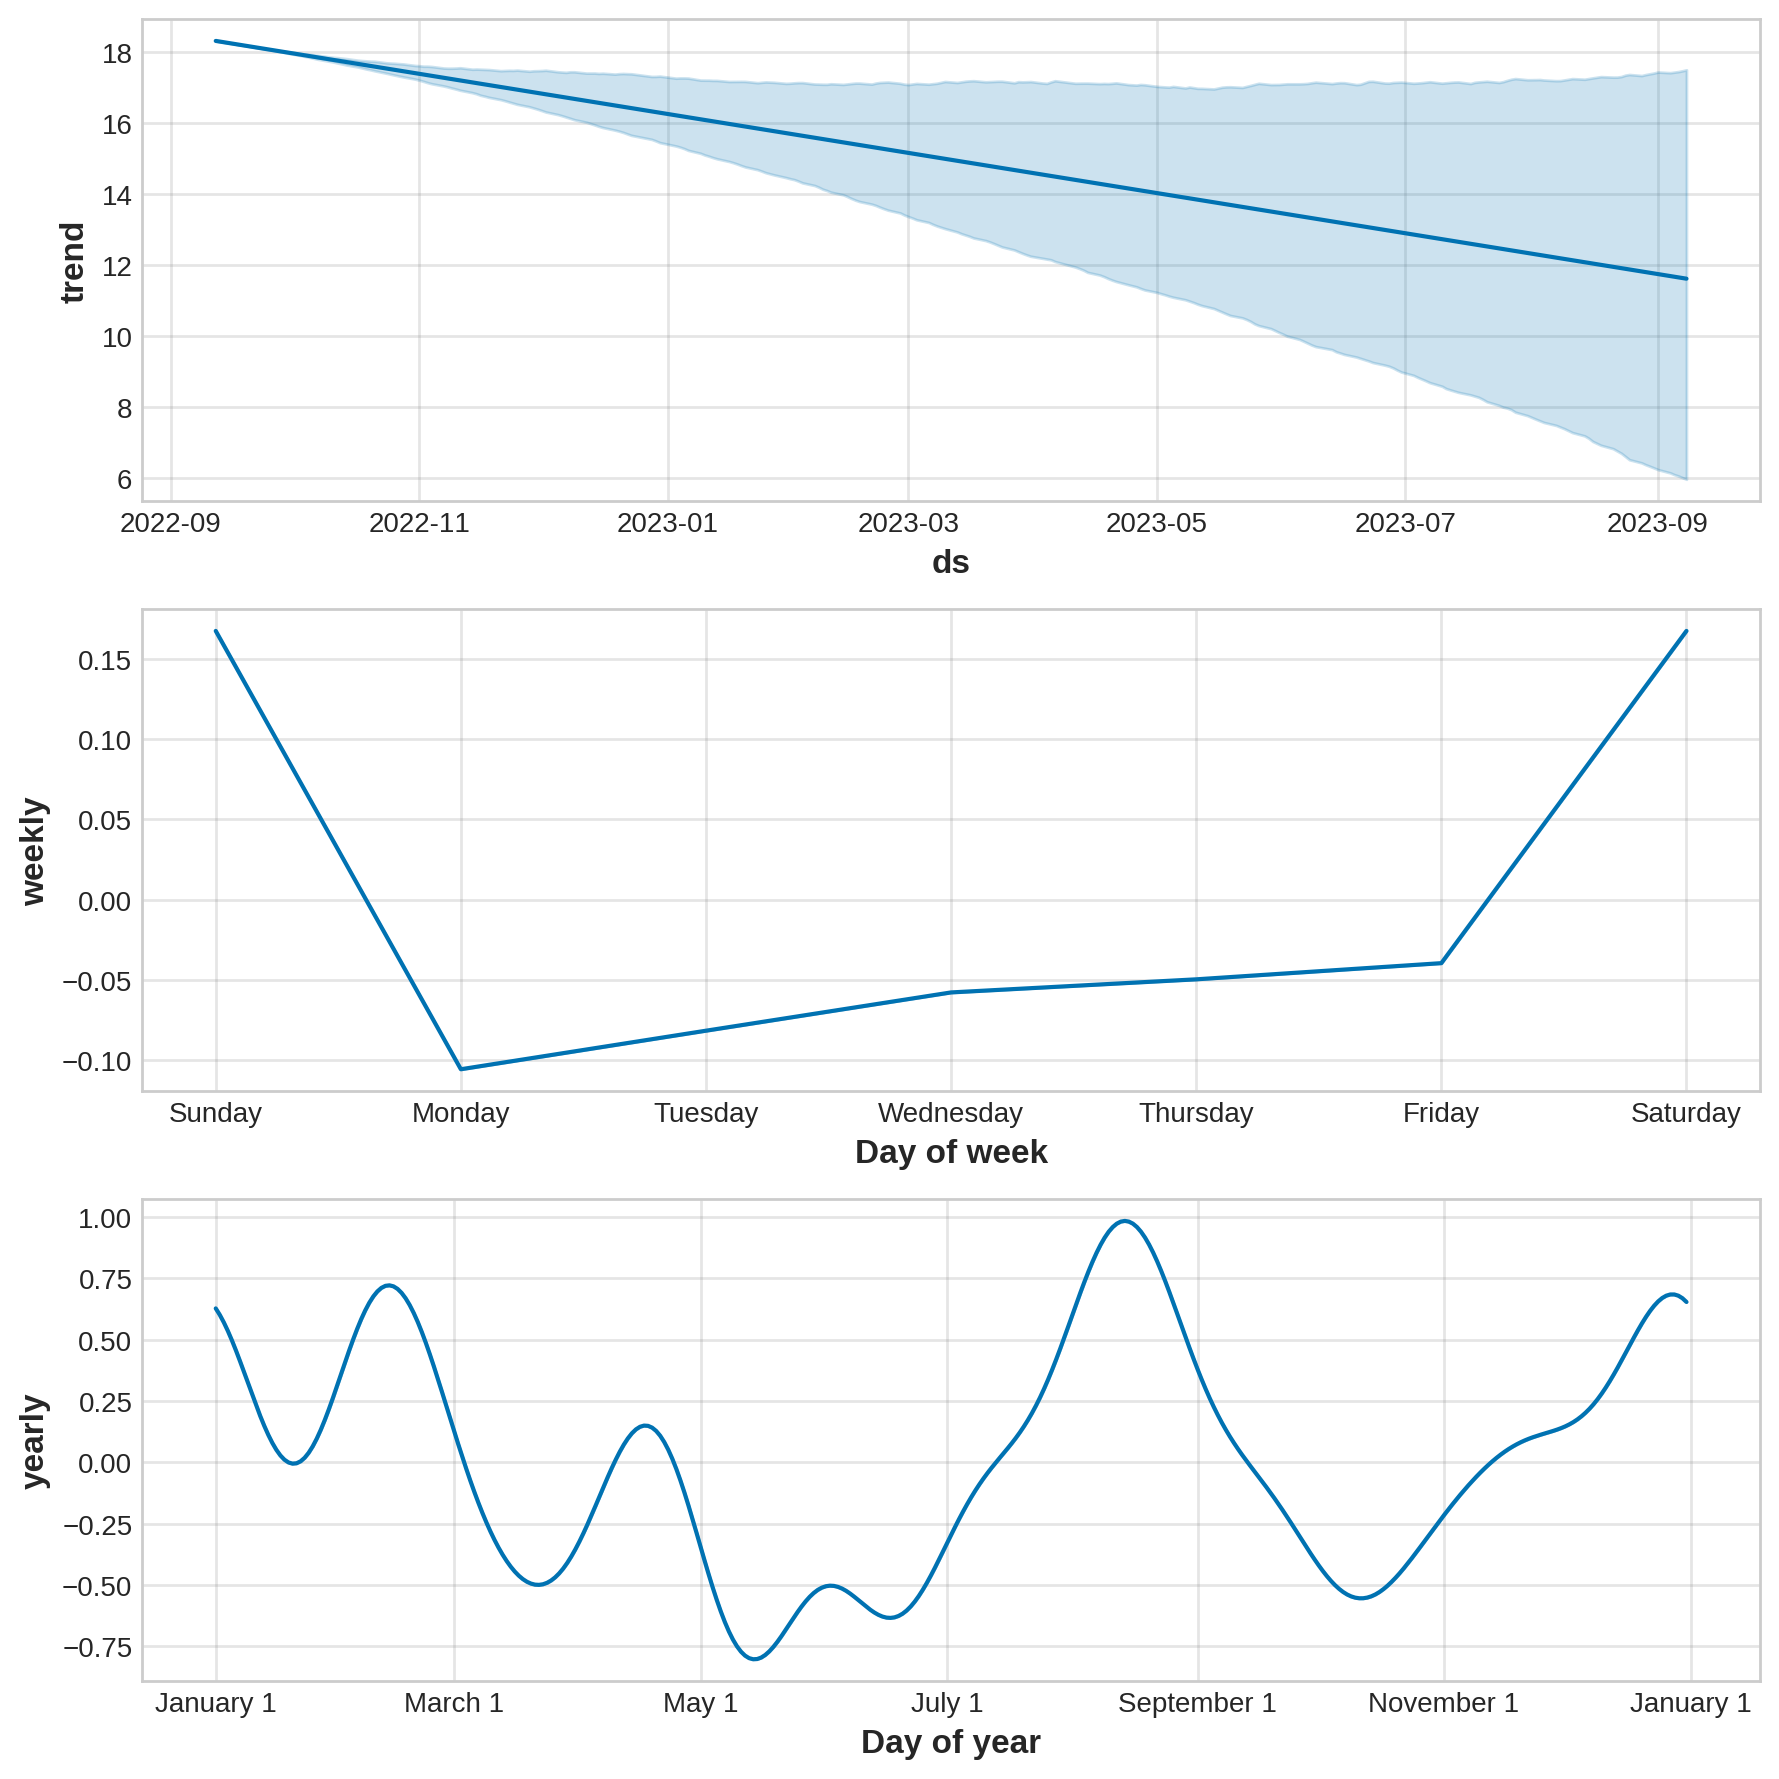

In [50]:
pp_model.plot_components(pred_pp)

In [51]:
data_test_pp.reset_index()['y']

0      18.873505
1      19.365517
2      18.391335
3      17.997728
4      17.515556
         ...    
246    23.170000
247    23.100000
248    23.090000
249    23.209999
250    23.190001
Name: y, Length: 251, dtype: float64

RMSE: 5.393394339546677


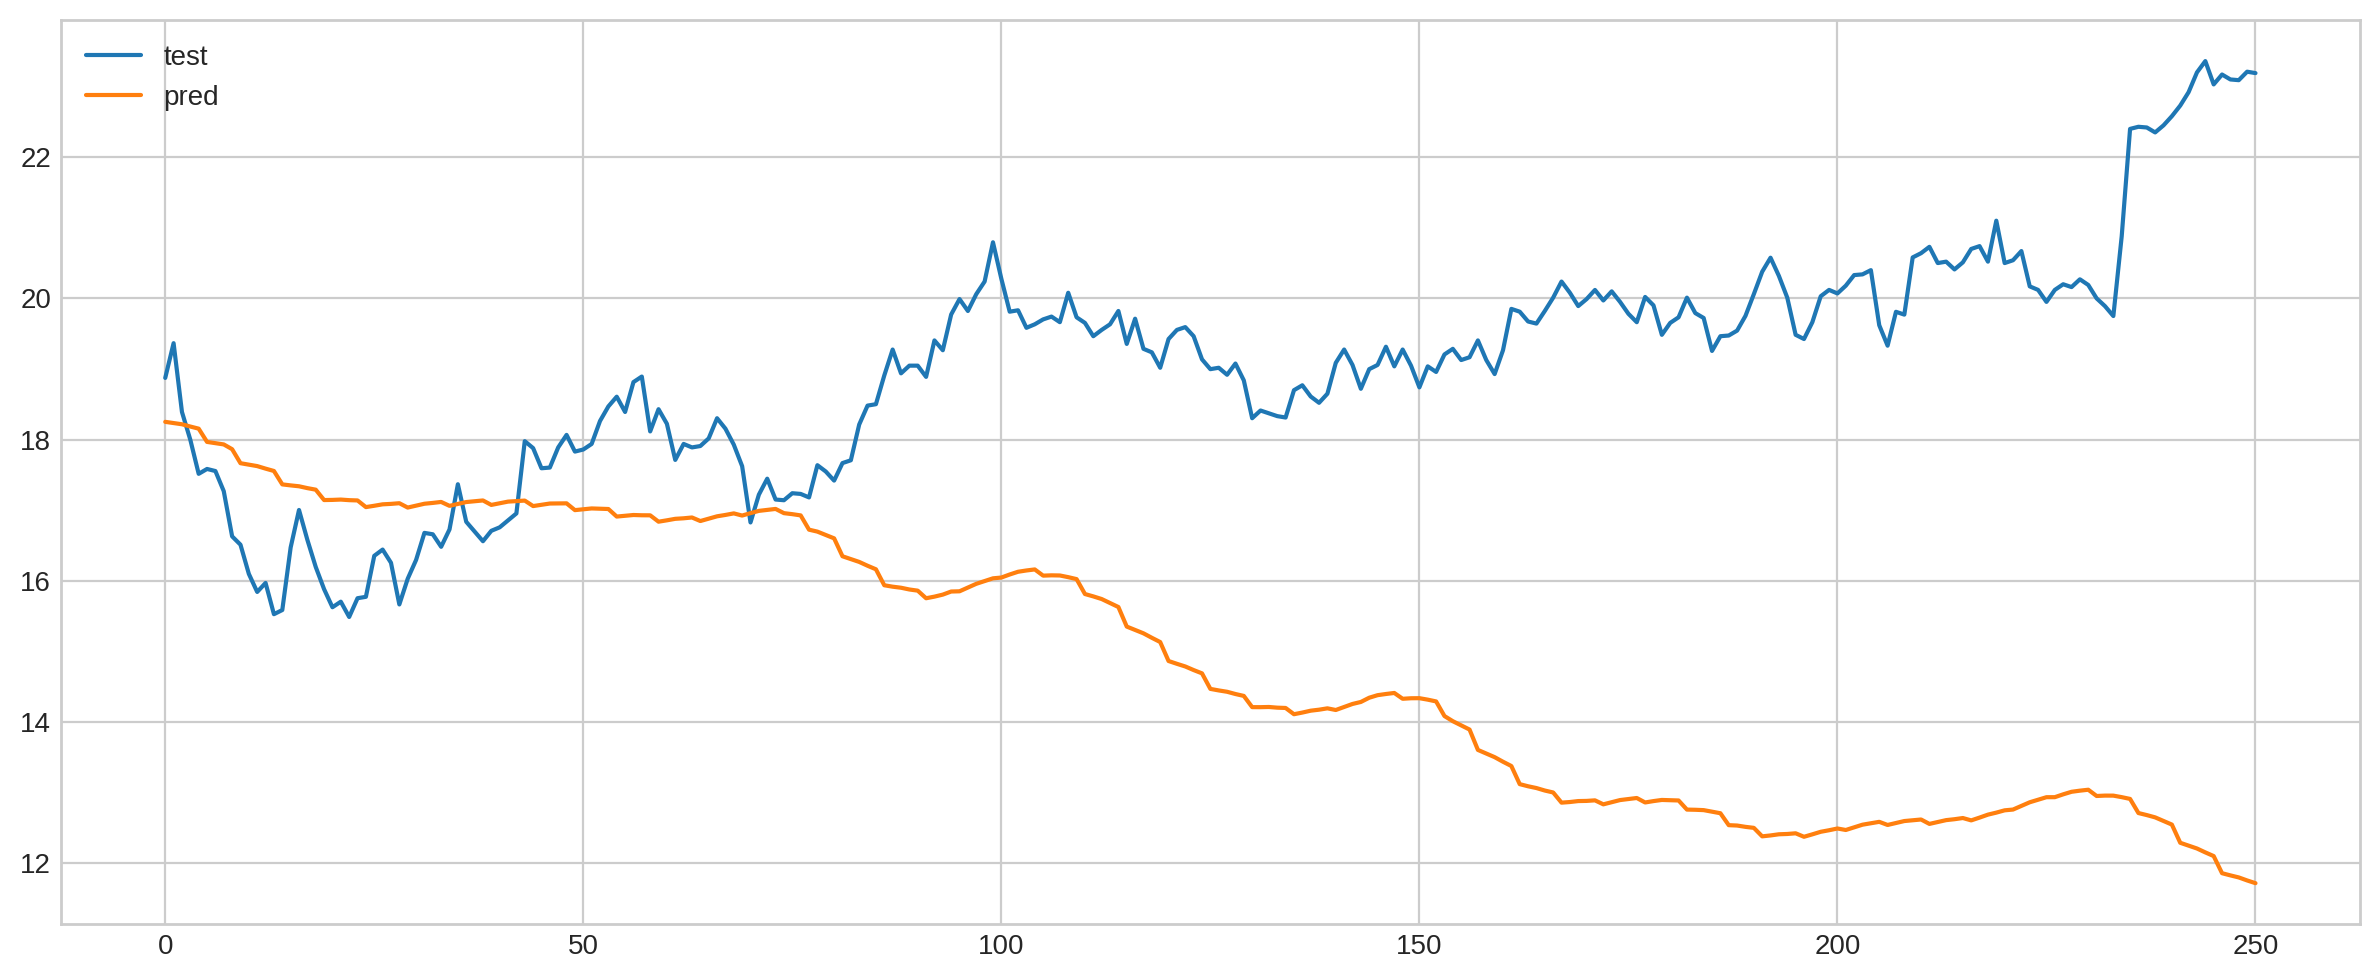

In [52]:
error = mean_squared_error(pred_pp['yhat'], data_test_pp['y'], squared=False)
print(f'RMSE: {error}')
plt.figure(figsize=(12, 5))
# plt.plot(data_train_pp['y'], label='train')
plt.plot(data_test_pp.reset_index()['y'], label='test')
plt.plot(pred_pp['yhat'], label='pred')
plt.legend()
plt.show()

As we can see, Prophet model performs not so well. So finally, I will use my Hybrid Model.

### Final Model

In [53]:
final_model =  HybridModel(
    model1 = LinearRegression(),
    model2 = XGBRegressor(random_state=42)
)

In [54]:
final_model.fit(X_train, y_train)

In [55]:
pred = final_model.predict(X_test)
err = mean_squared_error(pred, y_test)
print(f'RMSE : {err}')

RMSE : 1.2954028352792395


(1014, 10) (1014,) (251, 10) (251,)
Root Mean Squared Error of Model 0: 0.20189930840709316


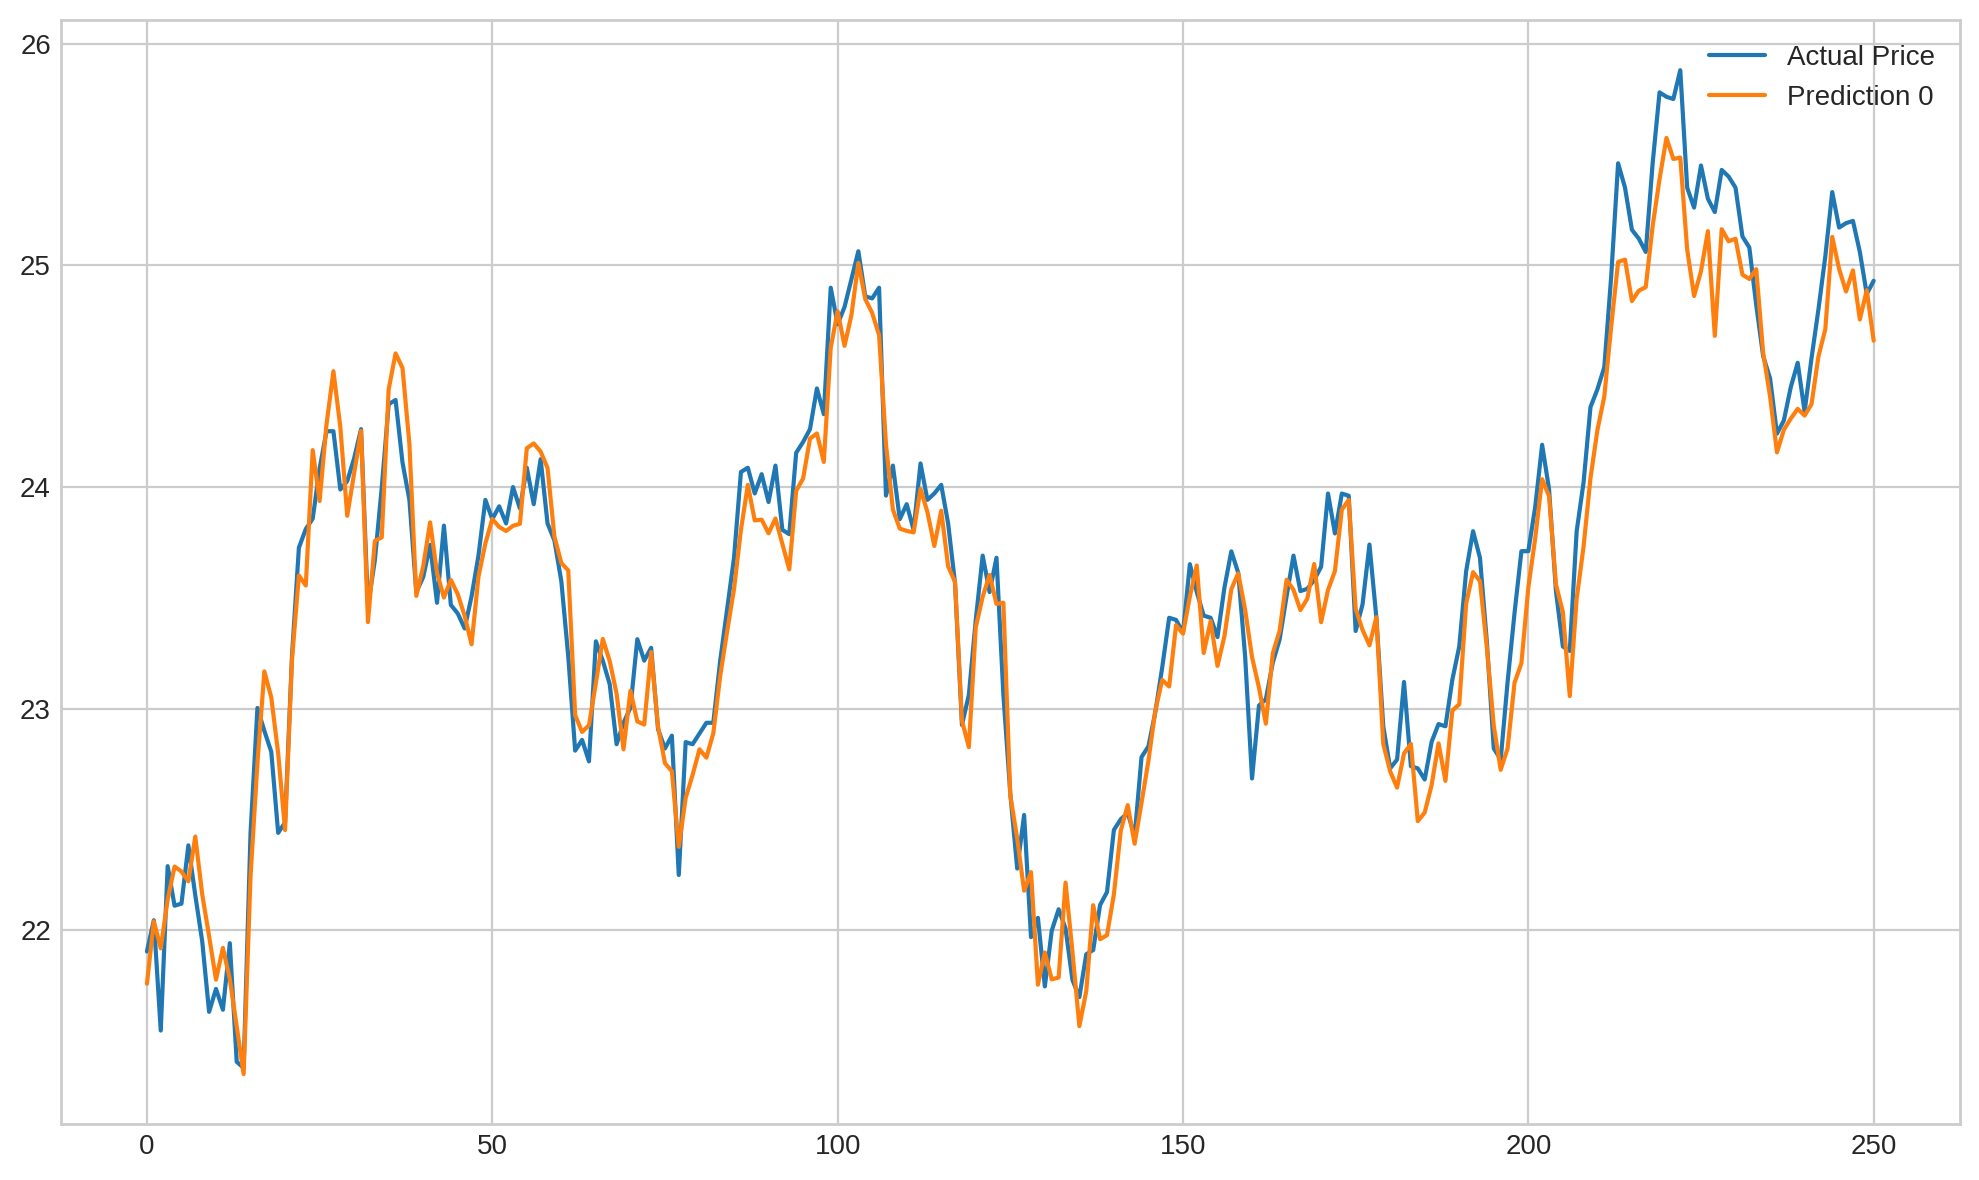

In [56]:
_ = show_result([final_model], data_train, data_test, 0, train_mode=False)

In [57]:
data.to_csv('stock_price_preprocessed.csv')

### Save model

In [59]:
model_filename = 'final_model.pkl'
joblib.dump(final_model, model_filename)

['final_model.pkl']

In [62]:
loaded_model = joblib.load(model_filename)

pred = loaded_model.predict(X_test)
err = mean_squared_error(pred, y_test)
print(f'RMSE : {err}')

RMSE : 1.2954028352792395
